# AP-1 Figures

In [ ]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle
import ete3
### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


## Functions

In [ ]:

def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [ ]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [ ]:
def signmoid(x):
    result = 1/(1 + np.exp(-x))
    return result

In [ ]:
def calculateVIF(features):
    '''
    calculates the VIF for each feature
    inputs: features, n X m (numSamples x numFeatures) vector of features
    output: VIFS, list of m VIFS
    '''
    vifs = []
    all_motifs = features.columns.values
    for motif in all_motifs:
        current_motif_scores = features[[motif]]
        other_motif_scores = features[[x for x in all_motifs if not x == motif]]
        lr = sklearn.linear_model.LinearRegression(n_jobs=-1)
        lr.fit(other_motif_scores, current_motif_scores)
        
        # calculate the coefficient of determination
        coeff_det = lr.score(other_motif_scores, current_motif_scores)
        # calculate VIF
        vif = 1/(1-coeff_det)
        vifs.append(vif)
    toReturn = pd.Series(data = vifs, index = all_motifs)
    return toReturn

## Copy Score Files

In [ ]:
%%bash
# random background files
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_count_background_frame_C57BL6J.pickle3 ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_score_background_frame_C57BL6J.pickle3 ./  
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_start_background_frame_C57BL6J.pickle3 ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_end_background_frame_C57BL6J.pickle3 ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_sequence_background_frame_C57BL6J.pickle3 ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/motif_strand_background_frame_C57BL6J.pickle3 ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/C57BL6J_background.fa ./

## Read in Score Files

In [ ]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle2')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle2')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle2')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle2')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle2')
motif_count_frame=pd.read_pickle('motif_count_frame_C57BL6J.pickle2')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')
   

In [ ]:
motif_score_background_frame = pd.read_pickle('motif_score_background_frame_C57BL6J.pickle3')
motif_sequence_background_frame=pd.read_pickle('motif_sequence_background_frame_C57BL6J.pickle3')
motif_strand_background_frame=pd.read_pickle('motif_strand_background_frame_C57BL6J.pickle3')
motif_start_background_frame=pd.read_pickle('motif_start_background_frame_C57BL6J.pickle3')
motif_end_background_frame=pd.read_pickle('motif_end_background_frame_C57BL6J.pickle3')
motif_count_background_frame=pd.read_pickle('motif_count_background_frame_C57BL6J.pickle3')

# make sure background frames don't have IDs that overlap with target frame
motif_score_background_frame = motif_score_background_frame[~motif_score_background_frame.index.isin(motif_score_frame.index.values)]
motif_sequence_background_frame = motif_sequence_background_frame[~motif_sequence_background_frame.index.isin(motif_score_frame.index.values)]
motif_strand_background_frame = motif_strand_background_frame[~motif_strand_background_frame.index.isin(motif_score_frame.index.values)]
motif_start_background_frame = motif_start_background_frame[~motif_start_background_frame.index.isin(motif_score_frame.index.values)]
motif_end_background_frame = motif_end_background_frame[~motif_end_background_frame.index.isin(motif_score_frame.index.values)]
motif_count_background_frame = motif_count_background_frame[~motif_count_background_frame.index.isin(motif_score_frame.index.values)]


In [ ]:
columns = list(motif_score_frame.columns.values)
columns.remove('ID')
columns.remove('chr')
columns.remove('Factors')
motifs = columns
sorted_columns = ['ID', 'chr' , 'Factors'] + sorted(motifs)

motif_score_frame = motif_score_frame[sorted_columns]
motif_sequence_frame = motif_sequence_frame[sorted_columns]
motif_strand_frame = motif_strand_frame[sorted_columns]
motif_start_frame = motif_start_frame[sorted_columns]
motif_end_frame = motif_end_frame[sorted_columns]
motif_count_frame = motif_count_frame[sorted_columns]

motif_score_background_frame = motif_score_background_frame[sorted_columns]
motif_sequence_background_frame = motif_sequence_background_frame[sorted_columns]
motif_strand_background_frame = motif_strand_background_frame[sorted_columns]
motif_start_background_frame = motif_start_background_frame[sorted_columns]
motif_end_background_frame = motif_end_background_frame[sorted_columns]
motif_count_background_frame = motif_count_background_frame[sorted_columns]

In [ ]:
# concatent target and background frames
# scores
all_score_frame = pd.concat([motif_score_frame, motif_score_background_frame])
all_score_frame = all_score_frame[motif_score_frame.columns.values]
all_score_frame = all_score_frame[sorted_columns]

# counts
all_count_frame = pd.concat([motif_count_frame, motif_count_background_frame])
all_count_frame = all_count_frame[motif_count_frame.columns.values]
all_count_frame = all_count_frame.ix[:,3:]
all_count_frame = all_count_frame[sorted(all_count_frame.columns.values)]

scaler = preprocessing.StandardScaler()
all_standardized_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_standardized_score_frame.columns = all_score_frame.columns.values[3:]
all_standardized_score_frame.index = all_score_frame.index.values
all_standardized_score_frame = all_standardized_score_frame[sorted(all_standardized_score_frame.columns.values)]

scaler = preprocessing.MinMaxScaler()
all_normed_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_normed_score_frame.columns = all_score_frame.columns.values[3:]
all_normed_score_frame.index = all_score_frame.index.values
all_normed_score_frame = all_normed_score_frame[sorted(all_normed_score_frame.columns.values)]

scaler = preprocessing.StandardScaler()
all_standardized_count_frame = pd.DataFrame(scaler.fit_transform(all_count_frame))
all_standardized_count_frame.columns = all_count_frame.columns.values
all_standardized_count_frame.index = all_count_frame.index.values
all_standardized_count_frame = all_standardized_count_frame[sorted(all_standardized_count_frame.columns.values)]

scaler = preprocessing.MinMaxScaler()
all_normed_count_frame = pd.DataFrame(scaler.fit_transform(all_count_frame))
all_normed_count_frame.columns = all_count_frame.columns.values
all_normed_count_frame.index = all_count_frame.index.values
all_normed_count_frame = all_normed_count_frame[sorted(all_normed_count_frame.columns.values)]

In [ ]:
# Read in peak sequence
### read in target sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  
### read in background sequences
with open('./C57BL6J_background.fa') as f:
    data = f.readlines()

for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

In [ ]:
ap1_members=['atf3', 'cjun', 'fos', 'junb', 'jund']
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

# Figure 1 - AP-1 Cistrome

### Expression of AP-1 monomers before and after KLA treatment

In [ ]:
%%bash
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*CR*/ ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*VML*/ ~/analysis/ap1_analysis/tag_directories_rna/*KLA-1h*UT*/> rpkm_untreated.tsv

# python ~/code/seq_merge_pipe/run_idr_homerRNA.py rpkm_untreated.tsv ./rna_idr_untreated KLA KLA Veh Veh

In [ ]:
# idr_rpkm_frame = pd.read_csv('./rna_idr_untreated/idr_union.tsv', sep='\t')

# columns = idr_rpkm_frame.columns.values
# columns[0] = "refseq"
# for i in range(len(columns)):
#     if "FPKM" in columns[i]:
#         columns[i] = '_'.join(columns[i].split('/')[-2].split('_')[3:5])
# idr_rpkm_frame.columns = columns    
# idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence'].values]
# idr_rpkm_frame.index = idr_rpkm_frame['gene'].values

# idr_rpkm_mean_frame = pd.DataFrame()

# for treatment in idr_rpkm_frame.columns.values[8:-1]:
#     idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment].astype(float), axis=1)

In [ ]:
# read in rpkm values
rpkm_frame = pd.read_csv('./rpkm_untreated.tsv', sep='\t')

rpkm_frame.index = [x.split('|')[0].upper() for x in rpkm_frame['Annotation/Divergence']]
rpkm_frame = rpkm_frame.ix[:,8:]
rpkm_frame.columns = [x.split('/')[-2].split('_')[3] for x in rpkm_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Treatment'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

In [ ]:
# from AP-1 as a regulator of cell life and death
# Jun (c-Jun, JunB, JunD), 
# Fos (c-Fos, FosB, Fra-1 and Fra2), 
# Maf (c-Maf, MafB, MafA, MafG/F/K and Nrl) and 
# ATF (ATF2, LRF1/ATF3, B-ATF, JDP1, JDP2) 
# BATF3 and JDP1 are the same thing
gene_list = ['JUN' , 'JUNB', 'JUND',
             'FOS', 'FOSL1', 'FOSL2', 'FOSB',
             'MAF', 'MAFA','MAFB','MAFG', 'MAFF', 'MAFK', 'NRL',
             'ATF2', 'ATF3','BATF','JDP2','BATF3'#'JDP1'
             ]
# gene_list = ['ATF3', 'FOS', 
#              'JUN' , 'JUNB', 'JUND']
plotting_frame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]
gene_list_tuples = []
for gene in set(plotting_frame['Gene'].values):
    vals = plotting_frame[plotting_frame['Gene']==gene]['Log2 RPKM'].values
    gene_list_tuples.append((gene, np.max(vals)))
gene_list_tuples.sort(key=lambda x:x[1])
ordered_genes = [x[0] for x in gene_list_tuples]
with sns.axes_style('ticks'):
    sns.factorplot(data = plotting_frame, 
                   x='Gene', 
                   y='Log2 RPKM', 
                   hue='Treatment', 
                   kind='bar', 
                   order = ordered_genes,
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)
    plt.xlabel('AP-1 Monomer')

plt.xticks(rotation=90)
plt.savefig('./figures/figure_01_a.svg', bbox_inches='tight')

### Heatmap of Vehicle Cistrome

In [ ]:
### create tag matrix
!annotatePeaks.pl ./merged_peaks_filtered_resized.tsv mm10 -size given -d ./tag_directories_ap1/* > merged_annotated_peaks_ap1.tsv

In [218]:
# average tag counts from both replicates
ap1_tag_frame = pd.read_csv('merged_annotated_peaks_ap1.tsv', sep='\t')
ap1_tag_frame.index = ap1_tag_frame.ix[:,0].values
ap1_tag_frame = ap1_tag_frame[[x for x in ap1_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[-1].lower() for x in ap1_tag_frame.columns.values]
ap1_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[3:5]).split('-')[0] for x in columns]))

ap1_meanTag_dict = {}
for ft in factor_treatments:
    ap1_meanTag_dict[ft] = ap1_tag_frame[[x for x in ap1_tag_frame.columns if ft in x]].mean(axis=1).values
ap1_meanTag_frame = pd.DataFrame(ap1_meanTag_dict)
ap1_meanTag_frame = ap1_meanTag_frame[factor_treatments]
ap1_meanTag_frame.index = ap1_tag_frame.index.values

In [ ]:
# clustermap for Vehicle
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1_veh')].index.values
data = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)]\
    [['ATF3_Veh','cJun_Veh', 'Fos_Veh', 'JunB_Veh', 'JunD_Veh','Input_Veh']]
# normalize by input
data = data.div((data['Input_Veh'] + 1), axis=0)
data = data.ix[:,:-1]
logged_data = np.log2(data+1)
cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=[x.split('_')[0] for x in data.columns],
          cmap='Blues',
          col_cluster=False,
          vmax=4
          )
plt.savefig('./figures/figure_01_b.svg', bbox_inches='tight')
plt.savefig('./figures/figure_01_b.png', bbox_inches='tight')

### Heatmap of KLA Cistrome

In [ ]:
# clustermap for KLA
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1_kla')].index.values
data = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)]\
    [['ATF3_KLA','cJun_KLA', 'Fos_KLA', 'JunB_KLA', 'JunD_KLA', 'p65_KLA','Input_KLA']]
data = data.div((data['Input_KLA'] + 1), axis=0)
data = data.ix[:,:-1]
logged_data = np.log2(data+1)
cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=[x.split('_')[0] for x in data.columns],
          cmap='Reds',
          col_cluster=False,
          vmax=4)
plt.savefig('./figures/figure_01_c.svg', bbox_inches='tight')
plt.savefig('./figures/figure_01_c.png', bbox_inches='tight')

### Heatmap for both Vehicle and KLA

In [ ]:
# clustermap for KLA
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1')].index.values
ap1_normedTag_frame = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)][[]]
for factor in ['ATF3','cJun', 'Fos', 'JunB', 'JunD', 'p65']:
    for treatment in ['Veh','KLA']:
        ft = factor + '_' + treatment
        ap1_normedTag_frame[ft] = (ap1_meanTag_frame[ft] + 1)/(ap1_meanTag_frame['Input_'+treatment]+1)

logged_data = np.log2(ap1_normedTag_frame+1)
cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=logged_data.columns,
          cmap='Greens',
          col_cluster=False,
          vmax=6)


In [ ]:
sns.clustermap(cg.data2d,
          yticklabels=False,
          xticklabels=logged_data.columns,
          cmap='Greens',
          col_cluster=False,
          row_cluster=False,
          vmin=0,
          vmax=6)

plt.savefig('./figures/figure_01_b-c.svg', bbox_inches='tight')
plt.savefig('./figures/figure_01_b-c.png', bbox_inches='tight')

In [ ]:
sorted_columns = []
for treatment in ['Veh', 'KLA']:
    for factor in ['ATF3','cJun', 'Fos', 'JunB', 'JunD', 'p65']:
        sorted_columns.append(factor + '_' + treatment)
    
sns.clustermap(cg.data2d[sorted_columns],
          yticklabels=False,
          xticklabels=sorted_columns,
          cmap='Greens',
          col_cluster=False,
          row_cluster=False,
          vmin=0,
          vmax=6)

# plt.savefig('./figures/figure_01_b-c.svg', bbox_inches='tight')
plt.savefig('./figures/figure_01_b-c_byTreatment.png', bbox_inches='tight')

### Stacked barplot summarizing overlap of peaks before and after KLA

In [ ]:
# ap1_members = ['atf3', 'cjun', 'fos', 'fra1', 'fra2','jdp2', 'junb', 'jund']
ap1_members = ['atf3', 'cjun', 'fos', 'junb', 'jund']
factor_list = []
count_list = []
type_list = []

veh_columns = ['c57bl6_' + x + '_veh' for x in ap1_members]
kla_columns = ['c57bl6_' + x + '_kla' for x in ap1_members]

for i in range(len(ap1_members)):
    factor = ap1_members[i]
    
        
    veh_indices = set(summary_frame[summary_frame['c57bl6_' + factor + '_veh'] > 0].index.values)
    kla_indices = set(summary_frame[summary_frame['c57bl6_' + factor + '_kla'] > 0].index.values)
        
    veh_count = len(veh_indices.difference(kla_indices))
    both_count = len(veh_indices.intersection(kla_indices))
    kla_count = len(kla_indices.difference(veh_indices))

    factor_list = factor_list + 3*[factor]
    type_list = type_list + ['Veh Specific', 'Shared', 'KLA Specific']
    count_list.append(veh_count)
    count_list.append(both_count)
    count_list.append(kla_count)
    
plotting_frame = pd.DataFrame({'Factor':factor_list,
                              'Type':type_list,
                              'Number of Peaks': count_list})
with sns.axes_style('ticks'):
    sns.factorplot(data=plotting_frame, 
                   x = 'Factor',
                   y = 'Number of Peaks',
                   hue = 'Type',
                   hue_order = ['Veh Specific', 'Shared', 'KLA Specific'],
                   kind = 'bar')

    plt.savefig('./figures/figure_01_d.png', bbox_inches='tight')
    plt.savefig('./figures/figure_01_d.svg', bbox_inches='tight')

### Phylogeny of AP-1 Monomers

In [ ]:
# protein tree built with clustalW
# run code on local machine with python 2.7 and et3 installed
# import ete3
# with open("/Users/jenhantao/Downloads/protein_tree.txt") as f:
#     data = f.readlines()
# tree_string = ''.join([x.strip() for x in data])
# tree = ete3.Tree(tree_string)
# ts = ete3.TreeStyle()
# ts.show_leaf_name = True
# ts.mode = "c"
# ts.arc_start = 0 
# ts.arc_span = 180
# # tree.show(tree_style=ts)
# tree.render("/Users/jenhantao/Desktop/tree_round.pdf", w=3,h=3, dpi=200, units="in",tree_style=ts)
# tree.render("/Users/jenhantao/Desktop/tree_default.pdf", w=3,h=3, dpi=200, units="in")

# Figure 2 - De Novo Motif Analysis

In [ ]:
%%bash
### create motif analysis directories
if [ ! -d ./denovo_motif_analysis ]; 
then 
    # make directories for peaks
    mkdir ./denovo_motif_analysis;
    mkdir ./denovo_motif_analysis/veh_peaks;
    mkdir ./denovo_motif_analysis/kla_peaks;
    mkdir ./denovo_motif_analysis/veh_nonoverlapping_peaks;
    mkdir ./denovo_motif_analysis/kla_nonoverlapping_peaks;
    mkdir ./denovo_motif_analysis/veh_monomers_peaks;
    mkdir ./denovo_motif_analysis/kla_monomers_peaks;
    
    # make directories for motif analysis
    mkdir ./denovo_motif_analysis/veh_motif_analysis_overlapping;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_overlapping;
    mkdir ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping;
    mkdir ./denovo_motif_analysis/veh_motif_analysis_monomers;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_monomers;
    
    # make directories for top motifs
    mkdir ./denovo_motif_analysis/top_motifs_kla_overlapping;
    mkdir ./denovo_motif_analysis/top_motifs_veh_overlapping;
    mkdir ./denovo_motif_analysis/top_motifs_veh_nonoverlapping;
    mkdir ./denovo_motif_analysis/top_motifs_kla_nonoverlapping;
    mkdir ./denovo_motif_analysis/top_motifs_veh_monomers;
    mkdir ./denovo_motif_analysis/top_motifs_kla_monomers;
else
    rm -rf ./denovo_motif_analysis/*/*
fi


### For overlapping dimer and monomer peaks

In [ ]:
### create peak files for denovo motif
peak_threshold = 50 # minimum number of peaks required for running motif analysis
factors = ['atf3', 'cjun', 'fos','junb', 'jund']

for treatment in ['veh', 'kla']:
    for i in range(len(factors)):
        factor1 = 'c57bl6_'+factors[i] + '_' + treatment
        for j in range(i, len(factors)):
            factor2 = 'c57bl6_'+ factors[j] + '_' + treatment

            if factor1 == factor2:
                outputPath = './denovo_motif_analysis/' + treatment + '_monomers_peaks/' + factor1 + '_peaks.tsv'

                current_frame = summary_frame[(summary_frame[factor1] > 0)]
            else:
                outputPath = './denovo_motif_analysis/' + treatment + '_peaks/' + factor1 + '_' + factor2 + '_peaks.tsv'
                current_frame = summary_frame[(summary_frame[factor1]> 0) &
                                             (summary_frame[factor2] > 0)]
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                outputPath = outputPath.replace('c57bl6_','')
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

In [ ]:
%%bash
for peakFile in ./denovo_motif_analysis/veh_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_overlapping/${peakName} -size 200 -len 8 -p 8 -S 10 &
    
done


In [ ]:
%%bash
for peakFile in ./denovo_motif_analysis/kla_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_overlapping/${peakName} -size 200 -len 8 -p 8 -S 10 &
done

In [ ]:
%%bash
rm -rf ./denovo_motif_analysis/veh_motif_analysis_monomers/*
for peakFile in ./denovo_motif_analysis/veh_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_monomers/${peakName} -size 200 -len 8 -p 8 -S 25 &
    
done

In [ ]:
%%bash
rm -rf ./denovo_motif_analysis/kla_motif_analysis_monomers/*
for peakFile in ./denovo_motif_analysis/kla_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_monomers/${peakName} -size 200 -len 8 -p 8 -S 25 &
    
done

### For nonoverlapping dimer peaks

In [306]:
### create peak files for denovo motif analysis 
peak_threshold = 50 # minimum number of peaks required for running motif analysis

factorPairs = []
# ap1_members = ['atf3','cjun', 'fos', 'fra1','fra2', 'jdp2', 'junb','jund']    
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    


for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

for treatment in ['veh', 'kla']:
    c57bl6_columns = ['c57bl6_' + x + '_' + treatment for x in ap1_members]
    for i in range(len(factorPairs)):
        monomer1 = factorPairs[i][0] + '_' + treatment
        monomer2 = factorPairs[i][1] + '_' + treatment
            
        outputPath = './denovo_motif_analysis/' + treatment + '_nonoverlapping_peaks/' + \
            '-'.join(factorPairs[i]).replace('c57bl6_','') + '_nonoverlapping_peaks.tsv'
            
        current_frame = summary_frame[(summary_frame[[monomer1, monomer2]].sum(axis=1) == summary_frame[c57bl6_columns].sum(axis=1))
                                     & (summary_frame[monomer1] > 0) & (summary_frame[monomer2] > 0)]
        if current_frame.shape[0] >= peak_threshold:
            print(factorPairs[i], current_frame.shape)
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

('c57bl6_atf3', 'c57bl6_cjun') (1788, 40)


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('c57bl6_atf3', 'c57bl6_jund') (4793, 40)
('c57bl6_cjun', 'c57bl6_jund') (959, 40)
('c57bl6_atf3', 'c57bl6_cjun') (411, 40)
('c57bl6_atf3', 'c57bl6_fos') (1265, 40)
('c57bl6_atf3', 'c57bl6_junb') (69, 40)
('c57bl6_atf3', 'c57bl6_jund') (5181, 40)
('c57bl6_cjun', 'c57bl6_fos') (72, 40)
('c57bl6_cjun', 'c57bl6_jund') (253, 40)
('c57bl6_fos', 'c57bl6_jund') (864, 40)


### for non overlappinng monomer peaks

In [305]:
### create peak files for denovo motif analysis 
peak_threshold = 50 # minimum number of peaks required for running motif analysis
strain = 'c57bl6'
factorPairs = []
# ap1_members = ['atf3','cjun', 'fos', 'fra1','fra2', 'jdp2', 'junb','jund']    
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

for treatment in ['veh', 'kla']:
    c57bl6_columns = ['c57bl6_' + x + '_' + treatment for x in ap1_members]
    for i in range(len(ap1_members)):
        monomer1 = strain + '_' +ap1_members[i] + '_' + treatment
            
        outputPath = './denovo_motif_analysis/' + treatment + '_nonoverlapping_peaks/' + \
            ap1_members[i].replace('c57bl6_','') + '_nonoverlapping_peaks.tsv'
            
        current_frame = summary_frame[(summary_frame[[monomer1]].sum(axis=1) == summary_frame[c57bl6_columns].sum(axis=1))
                                     & (summary_frame[monomer1] > 0)]
        if current_frame.shape[0] >= peak_threshold:
            print(ap1_members[i], current_frame.shape)
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

atf3 (5978, 40)


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cjun (2257, 40)
fos (239, 40)
junb (147, 40)
jund (3291, 40)
atf3 (7227, 40)
cjun (426, 40)
fos (1568, 40)
junb (75, 40)
jund (2771, 40)


In [ ]:
%%bash
for peakFile in ./denovo_motif_analysis/veh_nonoverlapping_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/${peakName} -size 200 -len 8 -p 8 -S 10 &
done

for peakFile in ./denovo_motif_analysis/kla_nonoverlapping_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping/${peakName} -size 200 -len 8 -p 8 -S 10 &
done

#### Get top motifs

In [ ]:
%%bash
# get top motif for all heterodimers


for i in ./denovo_motif_analysis/veh_motif_analysis_overlapping/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_veh_overlapping/${dimerName}.motif
done

for i in ./denovo_motif_analysis/kla_motif_analysis_overlapping/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_kla_overlapping/${dimerName}.motif
done

for i in ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_veh_nonoverlapping/${dimerName}.motif
done

for i in ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_kla_nonoverlapping/${dimerName}.motif
done

for i in ./denovo_motif_analysis/veh_motif_analysis_monomers/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_veh_monomers/${dimerName}.motif
done

for i in ./denovo_motif_analysis/kla_motif_analysis_monomers/*; 
do dimerName=${i##*/}
cp $i/homerResults/motif1.motif ./denovo_motif_analysis/top_motifs_kla_monomers/${dimerName}.motif
done

In [ ]:
%%bash
#create sequence logos for each top motif
mkdir ./denovo_motif_analysis/top_motifs_veh_overlapping_logos
mkdir ./denovo_motif_analysis/top_motifs_kla_overlapping_logos
mkdir ./denovo_motif_analysis/top_motifs_veh_nonoverlapping_logos
mkdir ./denovo_motif_analysis/top_motifs_kla_nonoverlapping_logos
mkdir ./denovo_motif_analysis/top_motifs_veh_monomers_logos
mkdir ./denovo_motif_analysis/top_motifs_kla_monomers_logos

for i in ./denovo_motif_analysis/top_motifs_veh_overlapping/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_kla_overlapping/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_veh_nonoverlapping/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_kla_nonoverlapping/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_veh_monomers/*; 
do motif2Logo.pl $i
done
for i in ./denovo_motif_analysis/top_motifs_kla_monomers/*; 
do motif2Logo.pl $i
done
mv ./denovo_motif_analysis/top_motifs_veh_overlapping/*png ./denovo_motif_analysis/top_motifs_veh_overlapping_logos
mv ./denovo_motif_analysis/top_motifs_kla_overlapping/*png ./denovo_motif_analysis/top_motifs_kla_overlapping_logos
mv ./denovo_motif_analysis/top_motifs_veh_nonoverlapping/*png ./denovo_motif_analysis/top_motifs_veh_nonoverlapping_logos
mv ./denovo_motif_analysis/top_motifs_kla_nonoverlapping/*png ./denovo_motif_analysis/top_motifs_kla_nonoverlapping_logos
mv ./denovo_motif_analysis/top_motifs_veh_monomers/*png ./denovo_motif_analysis/top_motifs_veh_monomers_logos
mv ./denovo_motif_analysis/top_motifs_kla_monomers/*png ./denovo_motif_analysis/top_motifs_kla_monomers_logos

## Browser shot for overlapping dimers

In [ ]:
atf3_labels = summary_frame['Factors'].str.contains('c57bl6_atf3_veh')
jund_labels = summary_frame['Factors'].str.contains('c57bl6_jund_veh')

cjun_labels = summary_frame['Factors'].str.contains('c57bl6_cjun_veh')
fos_labels = summary_frame['Factors'].str.contains('c57bl6_fos_veh')

In [ ]:
summary_frame[~cjun_labels & ~fos_labels & atf3_labels & jund_labels][['chr', 'start', 'end', 
                                         'c57bl6_atf3_veh', 
                                         'c57bl6_jund_veh', 
                                         'c57bl6_cjun_veh', 
                                         'c57bl6_fos_veh']].sort('c57bl6_atf3_veh', ascending=False)

In [ ]:
summary_frame[cjun_labels & fos_labels & ~atf3_labels & ~jund_labels][['chr', 'start', 'end', 
                                         'c57bl6_atf3_veh', 
                                         'c57bl6_jund_veh', 
                                         'c57bl6_cjun_veh', 
                                         'c57bl6_fos_veh']].sort_values(by='c57bl6_fos_veh', ascending=False)

### Browser shot for nonoverlapping dimers

In [ ]:
summary_frame[cjun_labels & fos_labels & atf3_labels & jund_labels][['chr', 'start', 'end', 
                                         'c57bl6_atf3_veh', 
                                         'c57bl6_jund_veh', 
                                         'c57bl6_cjun_veh', 
                                         'c57bl6_fos_veh']].sort('c57bl6_fos_veh', ascending=False)

### Schematic showing top motif analysis for all overlapping dimer sites

## Hierarchical clustering of de-novo motifs from all heterodimers

#### Overlapping heterodimers

In [ ]:
!python /home/jtao/code/motif_tools/scoreMotifs.py ./denovo_motif_analysis/top_motifs_veh_monomers/ ./denovo_motif_analysis/top_motifs_veh_monomers/scores

In [ ]:
dimers = [x.replace('.motif','',) for x in os.listdir('./denovo_motif_analysis/top_motifs_veh_monomers/') if '.motif' in x]

In [ ]:
correlations = np.load('./denovo_motif_analysis/top_motifs_veh_monomers/scores/correlation.npz')['arr_0']

distances = []
for i in range(correlations.shape[0] - 1):
    for j in range(i + 1, correlations.shape[0]):
        distances.append( 1 - correlations[i][j])
distances = np.array(distances)

linkage = scipy.cluster.hierarchy.linkage(distances)

with sns.axes_style('ticks'):
    scipy.cluster.hierarchy.dendrogram(linkage, labels = dimers);
    sns.despine()
    plt.xticks(rotation=90)
    plt.xlabel('Heterodimer')
    plt.ylabel('Height')
plt.savefig('./figures/supplementary - veh motif dendrogram.svg', bbox_inches='tight')

#### Nonoverlapping Heterodimers

In [ ]:
!python /home/jtao/code/motif_tools/scoreMotifs.py ./denovo_motif_analysis/top_motifs_kla_monomers/ ./denovo_motif_analysis/top_motifs_kla_monomers/scores

In [ ]:
dimers = [x.replace('.motif','',) for x in os.listdir('./denovo_motif_analysis/top_motifs_kla_monomers') if '.motif' in x]

In [ ]:

correlations = np.load('./denovo_motif_analysis/top_motifs_kla_monomers/scores/correlation.npz')['arr_0']

distances = []
for i in range(correlations.shape[0] - 1):
    for j in range(i + 1, correlations.shape[0]):
        distances.append( 1 - correlations[i][j])
distances = np.array(distances)

linkage = scipy.cluster.hierarchy.linkage(distances)


plt.figure(figsize=(12,12))
with sns.axes_style('ticks'):
    scipy.cluster.hierarchy.dendrogram(linkage, labels = dimers);
    sns.despine()
    plt.xticks(rotation=90)
    plt.xlabel('Heterodimer')
    plt.ylabel('Height')
    plt.savefig('./figures/supplementary - kla motif dendrogram.svg', bbox_inches='tight')

### Stacked bar plot of known motif ranks

In [ ]:
motif_dir = './denovo_motif_analysis/veh_motif_analysis_overlapping/'
p_threshold = 0.01
numMotifs = 5
motif_rank_count_dict = {} # {motif: {rank:count}}
for p in os.listdir(motif_dir):
    tokens = p.split('_')
    if len(tokens) > 2:
        current_frame = pd.read_csv(motif_dir + p + '/knownResults.txt', sep='\t')
        current_significant_frame = current_frame[current_frame['P-value'].astype(float) < p_threshold]
        if current_frame.shape[0] >= numMotifs:
            top_motifs = current_significant_frame.ix[:numMotifs-1,'Motif Name'].values
            
            for i in range(len(top_motifs)):
                motif = top_motifs[i]
                if not motif in motif_rank_count_dict:
                    motif_rank_count_dict[motif] = {x+1:0 for x in range(numMotifs)} # initialize dictionary
                motif_rank_count_dict[motif][i+1] += 1
        else:
            print(p, 'is missing motifs')
sorted_motifs = sorted(motif_rank_count_dict.keys())

rank_dict = {x+1:[] for x in range(numMotifs)} # {rank:count} create dictionary for creating data frame, sorted_motifs will be index
for motif in sorted_motifs:
    for i in range(numMotifs):
        rank_dict[i + 1].append(motif_rank_count_dict[motif][i+1])
motif_rank_frame = pd.DataFrame(rank_dict)
motif_rank_frame.index = sorted_motifs
# clean up motif names
motif_rank_frame.index = [x.split('-ChIP')[0] for x in motif_rank_frame.index.values]

In [ ]:
with sns.axes_style('ticks'):
    motif_rank_frame.plot(kind='bar', stacked=True)
    sns.despine()
    plt.legend(title='Rank')
    plt.ylabel('Number of Ocurrences')
    plt.xlabel('Homer Motif')
    plt.savefig('./figures/figure_02_b.svg', bbox_inches='tight')

### Scan each monomer for top denovo motifs taken from all monomers

In [ ]:
def combineTopMotifs(numMotifs, denovo_result_dir, scanning_results_dir):
    if not os.path.isdir(scanning_results_dir):
        os.mkdir(scanning_results_dir)

    combinedFile = open(scanning_results_dir + '/combined.motif', 'w')

    # for each denovo motif analysis result for each monomer
    for monomer_result_dir in os.listdir(denovo_result_dir):
        for i in range(1, numMotifs+1):
            # construct path to motifs 1 through numMotifs
            motif_path = denovo_result_dir + '/' + monomer_result_dir + '/homerResults/motif' + str(i) + '.motif'
            # read in motif file
            if os.path.isfile(motif_path):
                with open(motif_path) as f:
                    data = f.readlines()

                # change motif header
                headerTokens = data[0].split('\t')
                newMotifName = monomer_result_dir + '_' + str(i) + ',' + headerTokens[1].split(',')[1]
                headerTokens[1] = newMotifName

                newHeader = '\t'.join(headerTokens)

                # write motif into combined file
                combinedFile.write(newHeader)
                for line in data[1:]: # skip header line
                    combinedFile.write(line)
    combinedFile.close()

In [ ]:
numMotifs = 10 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/veh_motif_analysis_monomers/'
scanning_results_dir = './denovo_motif_analysis/veh_motif_scanning/'
combineTopMotifs(numMotifs, denovo_result_dir, scanning_results_dir)

numMotifs = 10 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/kla_motif_analysis_monomers/'
scanning_results_dir = './denovo_motif_analysis/kla_motif_scanning/'
combineTopMotifs(numMotifs, denovo_result_dir, scanning_results_dir)



In [ ]:
%%bash
### scan for top denovo motifs
rm -rf ./denovo_motif_analysis/veh_motif_scanning/*/
for peakFile in ./denovo_motif_analysis/veh_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_scanning/${peakName} -nomotif -mknown ./denovo_motif_analysis/veh_motif_scanning/combined.motif -size 200 -p 8 &
    
done

rm -rf ./denovo_motif_analysis/kla_motif_scanning/*/
for peakFile in ./denovo_motif_analysis/kla_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_scanning/${peakName} -nomotif -mknown ./denovo_motif_analysis/kla_motif_scanning/combined.motif -size 200 -p 8 &
    
done

In [ ]:
def combineKnownMotifResults(scanning_results_dir):
    sorted_motif_names = None
    monomer_fractions_dict = {}
    for result_dir in os.listdir(scanning_results_dir):
        if os.path.isdir(scanning_results_dir + '/' + result_dir):
            knownResults_path = scanning_results_dir + '/' + result_dir + '/knownResults.txt'
            knownResults_frame = pd.read_csv(knownResults_path, sep='\t')
            motif_names = knownResults_frame['Motif Name'].values
            if sorted_motif_names == None:
                sorted_motif_names = sorted(motif_names)

            string_target_fractions = knownResults_frame['% of Target Sequences with Motif'].values
            target_fractions = np.array([float(x[:-1]) for x in string_target_fractions])

            string_background_fractions = knownResults_frame['% of Background Sequences with Motif'].values
            background_fractions = np.array([float(x[:-1]) for x in string_background_fractions])

            enrichment = target_fractions/background_fractions
            # sort fractions by motif name
            name_fraction_dict =  dict(zip(motif_names, target_fractions))
            sorted_fractions = [name_fraction_dict[x] for x in sorted_motif_names]

            monomer_fractions_dict[result_dir] = sorted_fractions
    monomer_fractions_frame = pd.DataFrame(monomer_fractions_dict, index = [x.split(',')[0] for x in sorted_motif_names])
    return monomer_fractions_frame

In [ ]:
# combine motif scanning results into one table
scanning_results_dir = './denovo_motif_analysis/veh_motif_scanning/'

veh_monomer_fractions_frame = combineKnownMotifResults(scanning_results_dir)

scanning_results_dir = './denovo_motif_analysis/kla_motif_scanning/'

kla_monomer_fractions_frame = combineKnownMotifResults(scanning_results_dir)

In [ ]:
plt.figure(figsize=(2,4))
data = veh_monomer_fractions_frame.ix[[x for x in veh_monomer_fractions_frame.index.values if not 'junb' in x and not 'fos' in x], 
                                      [x for x in veh_monomer_fractions_frame.columns.values if not 'junb' in x and not 'fos' in x]]
sns.heatmap(data,
           vmin =0,
#            vmax = 100,
           yticklabels=False,
            square=True,
           cmap = 'Blues')
plt.yticks(size=6);
plt.xticks(size=6);

plt.savefig('./figures/figure_02_b.svg')
plt.savefig('./figures/figure_02_b.png')

In [ ]:
plt.figure(figsize=(3,3))
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_veh'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_veh'] > 0].index.values)
matplotlib_venn.venn3([atf3_indices, cjun_indices, jund_indices], set_labels=['atf3', 'cjun', 'jund'])
plt.savefig('./figures/figure_02_c_venn.svg')
plt.savefig('./figures/figure_02_c_venn.png')

In [ ]:
fraction_list = []
threshold_list = []
factor_list = []
thresholds = np.arange(0,100,10)
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_veh'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_veh'] > 0].index.values)

atf3_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(atf3_indices)]['atf3_veh']
cjun_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(cjun_indices)]['cjun_veh']
jund_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(jund_indices)]['jund_veh']
for threshold in thresholds:
    atf3_threshold = np.percentile(atf3_tagCounts, threshold)
    atf3_filtered_indices = set(atf3_tagCounts[atf3_tagCounts >= atf3_threshold].index.values)
    cjun_threshold = np.percentile(cjun_tagCounts, threshold)
    cjun_filtered_indices = set(cjun_tagCounts[cjun_tagCounts >= cjun_threshold].index.values)
    jund_threshold = np.percentile(jund_tagCounts, threshold)
    jund_filtered_indices = set(jund_tagCounts[jund_tagCounts >= jund_threshold].index.values)
    
    atf3_unique_indices = atf3_filtered_indices - (cjun_filtered_indices.union(jund_filtered_indices))
    cjun_unique_indices = cjun_filtered_indices - (atf3_filtered_indices.union(jund_filtered_indices))
    jund_unique_indices = jund_filtered_indices - (atf3_filtered_indices.union(cjun_filtered_indices))
#     print('atf3', threshold, atf3_threshold, len(atf3_filtered_indices), len(atf3_indices))
#     print('cjun', threshold, cjun_threshold, len(cjun_filtered_indices), len(cjun_indices))    
#     print('jund', threshold, jund_threshold, len(jund_filtered_indices), len(jund_indices))
    
    atf3_unique_fraction = len(atf3_unique_indices)/len(atf3_filtered_indices)
    cjun_unique_fraction = len(cjun_unique_indices)/len(cjun_filtered_indices)
    jund_unique_fraction = len(jund_unique_indices)/len(jund_filtered_indices)
    
    fraction_list.append(atf3_unique_fraction)
    fraction_list.append(cjun_unique_fraction)
    fraction_list.append(jund_unique_fraction)
    threshold_list = threshold_list + 3*[threshold]
    factor_list = factor_list + ['atf3', 'cjun', 'jund']
#     print('****', threshold, atf3_threshold, cjun_threshold, jund_threshold)
#     print(atf3_unique_fraction, cjun_unique_fraction, jund_unique_fraction)
#     print(len(atf3_filtered_indices), len(cjun_filtered_indices), len(jund_filtered_indices))
    

frame = pd.DataFrame({'Unique Peaks (% of Total Peaks)':fraction_list,
                      'Percentile Threshold':threshold_list,
                      'Monomer':factor_list}, 
                     )
with sns.axes_style('ticks'):
    sns.factorplot(data=frame, x = 'Percentile Threshold', y='Unique Peaks (% of Total Peaks)', hue='Monomer')
    plt.savefig('./figures/figure_02_c_fraction.png')
    plt.savefig('./figures/figure_02_c_fraction.svg')

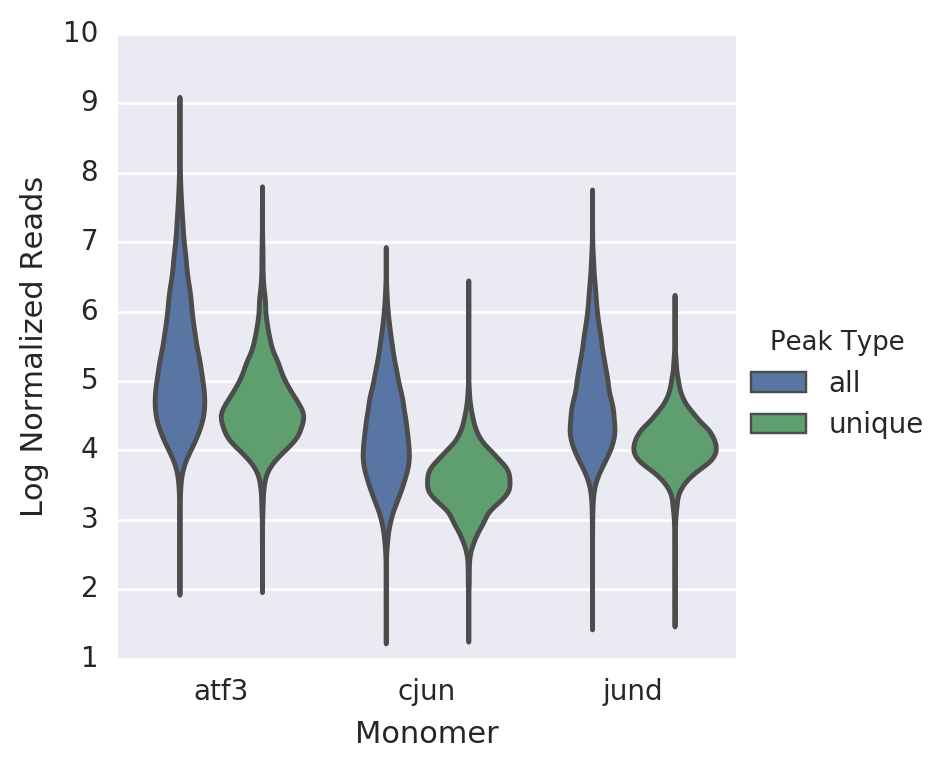

In [219]:
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_veh'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_veh'] > 0].index.values)
1
atf3_unique_indices = atf3_indices - (cjun_indices.union(jund_indices))
cjun_unique_indices = cjun_indices - (atf3_indices.union(jund_indices))
jund_unique_indices = jund_indices - (atf3_indices.union(cjun_indices))

atf3_tagCounts = list(ap1_meanTag_frame[ap1_meanTag_frame.index.isin(atf3_indices)]['atf3_veh'].values)
cjun_tagCounts = list(ap1_meanTag_frame[ap1_meanTag_frame.index.isin(cjun_indices)]['cjun_veh'].values)
jund_tagCounts = list(ap1_meanTag_frame[ap1_meanTag_frame.index.isin(jund_indices)]['jund_veh'].values)

atf3_unique_tagCounts = list(ap1_meanTag_frame[ap1_meanTag_frame.index.isin(atf3_unique_indices)]['atf3_veh'].values)
cjun_unique_tagCounts = list(ap1_meanTag_frame[ap1_meanTag_frame.index.isin(cjun_unique_indices)]['cjun_veh'].values)
jund_unique_tagCounts = list(ap1_meanTag_frame[ap1_meanTag_frame.index.isin(jund_unique_indices)]['jund_veh'].values)

tag_count_list = []
monomer_list = []
peakType_list = []

tag_count_list = tag_count_list + atf3_tagCounts + atf3_unique_tagCounts
monomer_list = monomer_list + (len(atf3_tagCounts) + len(atf3_unique_tagCounts)) * ['atf3']
peakType_list = peakType_list + len(atf3_tagCounts) *['all'] + len(atf3_unique_tagCounts) * ['unique']
tag_count_list = tag_count_list + cjun_tagCounts + cjun_unique_tagCounts
monomer_list = monomer_list + (len(cjun_tagCounts) + len(cjun_unique_tagCounts)) * ['cjun']
peakType_list = peakType_list + len(cjun_tagCounts) *['all'] + len(cjun_unique_tagCounts) * ['unique']
tag_count_list = tag_count_list + jund_tagCounts + jund_unique_tagCounts
monomer_list = monomer_list + (len(jund_tagCounts) + len(jund_unique_tagCounts)) * ['jund']
peakType_list = peakType_list + len(jund_tagCounts) *['all'] + len(jund_unique_tagCounts) * ['unique']

frame = pd.DataFrame({'Normalized Reads': tag_count_list,
                      'Log Normalized Reads': np.log2(np.array(tag_count_list) + 1),
                      'Monomer':monomer_list,
                      'Peak Type':peakType_list})

sns.factorplot(data = frame, 
               kind = 'violin', 
               x = 'Monomer', 
               y = 'Log Normalized Reads',
               hue = 'Peak Type', 
               showfliers = False,
               inner=None)

In [ ]:
plt.figure(figsize=(1,3))
sns.heatmap(kla_monomer_fractions_frame,
           vmin =0,
           vmax = 100,
           cmap='Blues',
           yticklabels=False)

### Create Bed Files for Use with GREAT

In [ ]:
outdir = './great_bed_files/'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
else:
    for f in os.listdir(outdir):
        os.remove(outdir + '/' + f)
strain = 'c57bl6'
for treatment in ['veh', 'kla']:
    for monomer in ['atf3', 'cjun', 'fos', 'junb', 'jund']:
        position_frame = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0][['chr', 'start', 'end']]
        position_frame.to_csv(outdir + '/' + strain + '_' + monomer + '_' + treatment + '.bed', 
                              sep='\t', 
                              header = False,
                              index=False)

In [ ]:
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_veh'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_veh'] > 0].index.values)

atf3_unique_indices = atf3_indices - (cjun_indices.union(jund_indices))
cjun_unique_indices = cjun_indices - (atf3_indices.union(jund_indices))
jund_unique_indices = jund_indices - (atf3_indices.union(cjun_indices))

position_frame = summary_frame[summary_frame.index.isin(atf3_unique_indices)][['chr', 'start', 'end']]
position_frame.to_csv(outdir + '/' + strain + '_unique_atf3_veh_' + treatment + '.bed', 
                      sep='\t', 
                      header = False,
                      index=False)
position_frame = summary_frame[summary_frame.index.isin(cjun_unique_indices)][['chr', 'start', 'end']]
position_frame.to_csv(outdir + '/' + strain + '_unique_cjun_veh_' + treatment + '.bed', 
                      sep='\t', 
                      header = False,
                      index=False)
position_frame = summary_frame[summary_frame.index.isin(jund_unique_indices)][['chr', 'start', 'end']]
position_frame.to_csv(outdir + '/' + strain + '_unique_jund_veh_' + treatment + '.bed', 
                      sep='\t', 
                      header = False,
                      index=False)

# Figure 3 - Machine Learning Overview

### Schematic of classifier workflow

## VIF Analysis for Features

In [ ]:
def calculateVIF(features):
    '''
    calculates the VIF for each feature
    inputs: features, n X m (numSamples x numFeatures) vector of features
    output: VIFS, list of m VIFS
    '''
    vifs = []
    all_motifs = features.columns.values
    for motif in all_motifs:
        current_motif_scores = features[[motif]]
        other_motif_scores = features[[x for x in all_motifs if not x == motif]]
        lr = sklearn.linear_model.LinearRegression(n_jobs=-1)
        lr.fit(other_motif_scores, current_motif_scores)
        
        # calculate the coefficient of determination
        coeff_det = lr.score(other_motif_scores, current_motif_scores)
        # calculate VIF
        if coeff_det == 1:
            vif = 10
        else:
            vif = 1/(1-coeff_det)
        vifs.append(vif)
    toReturn = pd.Series(data = vifs, index = all_motifs)
    return toReturn

In [ ]:
affinity_vifs = calculateVIF(all_score_frame[sorted(all_score_frame.columns.values[3:])])

count_vifs  = calculateVIF(all_count_frame)

In [ ]:
count_vifs[count_vifs > 10]

In [ ]:
affinity_vifs[affinity_vifs > 10]

In [ ]:
vif_frame = pd.DataFrame({'Data Type':['Count'] * len(count_vifs) + ['Affinity'] * len(affinity_vifs),
                          'VIF': np.concatenate([count_vifs.values, affinity_vifs.values]) 
                         })

In [ ]:
with sns.axes_style('ticks'):
    sns.factorplot(data = vif_frame,
                   x = 'Data Type',
                   y = 'VIF',
                   kind = 'box',
                  size=3)
plt.ylim(0,20)
plt.plot([-1,3], [10,10], c = 'black', linestyle='--')
plt.savefig('./figures/supplementary - VIF analysis.png')
plt.savefig('./figures/supplementary - VIF analysis.svg')

## Figure 4 - Motifs for Vehicle Dimers

In [193]:
def train_ensemble_classifier(affinity_features,
                              count_features, 
                              labels,
                              numIterations = 5,
                              test_size = 0.5,
                             ):
    '''
    
    '''
    all_rocs = []
    all_affinity_rocs = []
    all_count_rocs = []

    all_precisions = []
    all_affinity_precisions = []
    all_count_precisions = []
    
    all_coefficients = []
    all_affinity_coefficients = []
    all_count_coefficients = []

    for i in range(numIterations):  

        # split data into training and test sets
        training_affinity_features, test_affinity_features, training_labels, test_labels = get_split(
            affinity_features, labels, test_size = test_size)
        training_count_features = count_features[count_features.index.isin(training_affinity_features.index.values)]
        test_count_features = count_features[count_features.index.isin(test_affinity_features.index.values)]
        #  Train affinity classifier
        affinity_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
        affinity_classifier.fit(training_affinity_features, training_labels)

        # Train count classifier
        count_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
        count_classifier.fit(training_count_features, training_labels)

        # train combined classifier
        training_affinity_scores = affinity_classifier.decision_function(training_affinity_features)
        training_count_scores = count_classifier.decision_function(training_count_features)
        training_combined_features = pd.DataFrame({'Affinity':training_affinity_scores,
                                         'Count':training_count_scores})
        combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
        combined_classifier.fit(training_combined_features, training_labels)

        # retrieve test probabilities
        test_affinity_scores = affinity_classifier.decision_function(test_affinity_features)
        test_count_scores = count_classifier.decision_function(test_count_features)
        test_combined_features = pd.DataFrame({'Affinity':test_affinity_scores,
                                                   'Count':test_count_scores})

        # score predictions
        affinity_probas = affinity_classifier.predict_proba(test_affinity_features)
        current_affinity_rocs = sklearn.metrics.roc_auc_score(test_labels, affinity_probas[:, 1], average = None)
        current_affinity_precision = sklearn.metrics.average_precision_score(test_labels, affinity_probas[:, 1], average = None)
        
        count_probas = count_classifier.predict_proba(test_count_features)
        current_count_rocs = sklearn.metrics.roc_auc_score(test_labels, count_probas[:, 1], average = None)
        current_count_precision = sklearn.metrics.average_precision_score(test_labels, count_probas[:, 1], average = None)
    
        probas = combined_classifier.predict_proba(test_combined_features)
        current_rocs = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
        current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

         # retrieve coefficients
        current_coefficients = combined_classifier.coef_.flatten()
        current_affinity_coefficients = affinity_classifier.coef_.flatten()
        current_count_coefficients = count_classifier.coef_.flatten()
        
        all_rocs.append(current_rocs)
        all_affinity_rocs.append(current_affinity_rocs)
        all_count_rocs.append(current_count_rocs)

        all_precisions.append(current_precision)
        all_affinity_precisions.append(current_affinity_precision)
        all_count_precisions.append(current_count_precision)

        all_coefficients.append(current_coefficients)
        all_affinity_coefficients.append(current_affinity_coefficients)
        all_count_coefficients.append(current_count_coefficients)      
    
#     mean_affinity_coefficients = np.mean(all_affinity_coefficients, axis=0)
#     mean_count_coefficients = np.mean(all_count_coefficients, axis=0)
        
    results = (all_rocs, 
               all_affinity_rocs, 
               all_count_rocs, 
               all_precisions, 
               all_affinity_precisions, 
               all_count_precisions,
               all_coefficients,
               all_affinity_coefficients,
               all_count_coefficients)
    return results




### All Motifs

In [194]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']

In [339]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'

factor_coeff_dict = {}
factor_affinityCoeff_dict = {}
factor_countCoeff_dict = {}

factor_roc_dict = {}
factor_affinity_roc_dict = {}
factor_count_roc_dict = {}

factor_precision_dict = {}
factor_affinity_precision_dict = {}
factor_count_precision_dict = {}

for treatment in ['veh', 'kla']:
    for monomer in factors:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
#         background_indices = motif_score_background_frame[
#             motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        background_indices = motif_score_background_frame.index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

#         target_affinity_features = all_normed_score_frame[all_normed_score_frame.index.isin(target_indices)]
#         background_affinity_features = all_normed_score_frame[all_normed_score_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        count_features = all_standardized_count_frame
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_ensemble_classifier(affinity_features, 
                                            count_features, 
                                            labels,
                                            numIterations = numIterations,
                                            test_size = test_size,
                                            )
        
        # unpack result tuples
        all_rocs = results[0]
        all_affinity_rocs = results[1]
        all_count_rocs = results[2]
        all_precisions = results[3]
        all_affinity_precisions = results[4]
        all_count_precisions = results[5]
        all_coefficients = results[6]
        all_affinity_coefficients = results[7]
        all_count_coefficients = results[8]
        
        factor_roc_dict[monomer + '_' + treatment] = all_rocs
        factor_affinity_roc_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_count_roc_dict[monomer + '_' + treatment] = all_count_rocs
       
        factor_precision_dict[monomer + '_' + treatment] = all_precisions
        factor_affinity_precision_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_count_precision_dict[monomer + '_' + treatment] = all_count_precisions
    
        factor_coeff_dict[monomer + '_' + treatment] = all_coefficients
        factor_affinityCoeff_dict[monomer + '_' + treatment] = all_affinity_coefficients
        factor_countCoeff_dict[monomer + '_' + treatment] = all_count_coefficients
        
        
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_rocs), np.mean(all_affinity_rocs), np.mean(all_count_rocs),
              'precision:', np.mean(all_precisions), np.mean(all_affinity_precisions), np.mean(all_count_precisions)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


23136 46272
atf3_veh roc: 0.951390350569 0.942904724532 0.885340127246 precision: 0.947106775963 0.937282606361 0.8804168151
15538 31076
cjun_veh roc: 0.949725843713 0.941350454338 0.880453456207 precision: 0.948636223067 0.939672207464 0.877385649146
542 1084
fos_veh roc: 0.736771013467 0.695935512861 0.697016652823 precision: 0.751578089024 0.699362335563 0.701783911997
462 924
junb_veh roc: 0.791190195086 0.75730214951 0.732819849703 precision: 0.799111466392 0.75949053514 0.73186653969
19624 39248
jund_veh roc: 0.953017508823 0.945734836325 0.881041858443 precision: 0.950940151515 0.942484465497 0.879499623808
12870 25740
cebpa_veh roc: 0.966765405535 0.958961357041 0.90158264493 precision: 0.964584374163 0.95640067202 0.895285650183
41511 83022
pu1_veh roc: 0.945038296514 0.937045058376 0.855848248223 precision: 0.940567456454 0.932153401052 0.851213450353
286 572
p65_veh roc: 0.944085285344 0.934539586288 0.893784537141 precision: 0.952644802996 0.944856539606 0.907669430595
3671

### AP-1 Motif Only

In [340]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'

factor_coeff_ap1Only_dict = {}
factor_affinityCoeff_ap1Only_dict = {}
factor_countCoeff_ap1Only_dict = {}

factor_roc_ap1Only_dict = {}
factor_affinity_roc_ap1Only_dict = {}
factor_count_roc_ap1Only_dict = {}

factor_precision_ap1Only_dict = {}
factor_affinity_precision_ap1Only_dict = {}
factor_count_precision_ap1Only_dict = {}

for treatment in ['veh', 'kla']:
    for monomer in factors:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
#         background_indices = motif_score_background_frame[
#             motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        background_indices = motif_score_background_frame.index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        
#         target_affinity_features = all_normed_score_frame[all_normed_score_frame.index.isin(target_indices)]
#         background_affinity_features = all_normed_score_frame[all_normed_score_frame.index.isin(background_indices)]

        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        count_features = all_standardized_count_frame
        
        affinity_features = affinity_features[['ap-1','atf7_batf3_creb5']]
        count_features = all_count_frame[['ap-1','atf7_batf3_creb5']] 
        
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_ensemble_classifier(affinity_features, 
                                            count_features, 
                                            labels,
                                            numIterations = numIterations,
                                            test_size = test_size,
                                            )
        
        # unpack result tuples
        all_rocs = results[0]
        all_affinity_rocs = results[1]
        all_count_rocs = results[2]
        all_precisions = results[3]
        all_affinity_precisions = results[4]
        all_count_precisions = results[5]
        all_coefficients = results[6]
        all_affinity_coefficients = results[7]
        all_count_coefficients = results[8]
        
        factor_roc_ap1Only_dict[monomer + '_' + treatment] = all_rocs
        factor_affinity_roc_ap1Only_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_count_roc_ap1Only_dict[monomer + '_' + treatment] = all_count_rocs
       
        factor_precision_ap1Only_dict[monomer + '_' + treatment] = all_precisions
        factor_affinity_precision_ap1Only_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_count_precision_ap1Only_dict[monomer + '_' + treatment] = all_count_precisions
    
        factor_coeff_ap1Only_dict[monomer + '_' + treatment] = all_coefficients
        factor_affinityCoeff_ap1Only_dict[monomer + '_' + treatment] = all_affinity_coefficients
        factor_countCoeff_ap1Only_dict[monomer + '_' + treatment] = all_count_coefficients
        
        
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_rocs), np.mean(all_affinity_rocs), np.mean(all_count_rocs),
              'precision:', np.mean(all_precisions), np.mean(all_affinity_precisions), np.mean(all_count_precisions)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


23136 46272
atf3_veh roc: 0.800132441954 0.777014659783 0.71444469568 precision: 0.814493562047 0.797769438175 0.716182526765
15538 31076
cjun_veh roc: 0.803986430089 0.78985332543 0.706879285196 precision: 0.822144372999 0.811251069223 0.71051227585
542 1084
fos_veh roc: 0.696981250255 0.68138641903 0.648230552416 precision: 0.716385396501 0.715058107859 0.642792275419
462 924
junb_veh roc: 0.734978729784 0.719229399749 0.683907722869 precision: 0.768527016599 0.757051380281 0.699297028785
19624 39248
jund_veh roc: 0.754259142403 0.7490379541 0.65453621542 precision: 0.78213259966 0.777811320555 0.663867464953
12870 25740
cebpa_veh roc: 0.741823076863 0.685552460835 0.712505474324 precision: 0.75313929541 0.711661989874 0.714203218319
41511 83022
pu1_veh roc: 0.580092985022 0.574797906526 0.552958126915 precision: 0.608764696687 0.604832623523 0.560350293592
286 572
p65_veh roc: 0.602498899702 0.567612108172 0.544359137366 precision: 0.631419899176 0.619973928914 0.528772446033
36716 

### Combine Weights

In [377]:
def combine_weights(affinity_weights_dict, 
                    count_weights_dict,
                    ensemble_weights_dict,
                    sorted_motif_names):
    '''
    takes the output weights of train_ensemble_classifier and calculates a combined weight for each motif
    ensemble_weights[0] = affinity_classifier_weight
    ensemble_weights[1] = count_classifier_weight
    combined weight = affinity_classifier_weight * affinity_weight + count_classifier_weight * count_weight
    returns zscore normalized affinity_weights_dict, count_weights_dict, and combined weights in data frame form
    '''
    
    factor_zscore_coeff_affinity_dict = {}
    factor_zscore_coeff_count_dict = {}
    factor_zscore_coeff_combined_dict = {}

    # calculates the mean of each of the weights
    for monomer_treatment in affinity_weights_dict.keys():
        current_affinity_weights = affinity_weights_dict[monomer_treatment]
        mean_affinity_weights = np.mean(current_affinity_weights, axis=0)
        
        current_count_weights = count_weights_dict[monomer_treatment]
        mean_count_weights = np.mean(current_count_weights, axis=0)
        
        current_ensemble_weights = ensemble_weights_dict[monomer_treatment]
        mean_ensemble_weights = np.mean(current_ensemble_weights, axis=0)
        
        # zscore normalize the weights
        zscore_affinity_weights = scipy.stats.mstats.zscore(mean_affinity_weights)
        zscore_count_weights = scipy.stats.mstats.zscore(mean_count_weights)
        
        # combine weights
        affinity_classifier_weight = mean_ensemble_weights[0] 
        count_classifier_weight = mean_count_weights[0] 
        combined_weights = (affinity_classifier_weight * zscore_affinity_weights) + (count_classifier_weight * zscore_count_weights)
        zscore_combined_weights = scipy.stats.mstats.zscore(combined_weights)
        
        factor_zscore_coeff_affinity_dict[monomer_treatment] = zscore_affinity_weights
        factor_zscore_coeff_count_dict[monomer_treatment] = zscore_count_weights
        factor_zscore_coeff_combined_dict[monomer_treatment] = zscore_combined_weights
    
    zscore_coeff_affinity_frame = pd.DataFrame(factor_zscore_coeff_affinity_dict)
    zscore_coeff_count_frame = pd.DataFrame(factor_zscore_coeff_count_dict)
    zscore_coeff_combined_frame = pd.DataFrame(factor_zscore_coeff_combined_dict)
    
    zscore_coeff_affinity_frame.index = sorted_motif_names
    zscore_coeff_count_frame.index = sorted_motif_names
    zscore_coeff_combined_frame.index = sorted_motif_names
    
    return zscore_coeff_affinity_frame, zscore_coeff_count_frame, zscore_coeff_combined_frame

In [378]:
results = combine_weights(factor_affinityCoeff_dict,
                          factor_countCoeff_dict,
                          factor_coeff_dict,
                          all_standardized_score_frame.columns.values)
zscore_coeff_affinity_frame = results[0]
zscore_coeff_count_frame = results[1]
zscore_coeff_coumbined_frame= results[2]

coefficients_zscore_affinity_veh_frame = zscore_coeff_affinity_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
coefficients_zscore_affinity_kla_frame = zscore_coeff_affinity_frame[['atf3_kla', 'cjun_kla', 'fos_kla','junb_kla', 'jund_kla']]

coefficients_zscore_combined_veh_frame = zscore_coeff_coumbined_frame[['atf3_veh', 'cjun_veh', 'jund_veh']]
coefficients_zscore_combined_kla_frame = zscore_coeff_coumbined_frame[['atf3_kla', 'cjun_kla', 'fos_kla','junb_kla', 'jund_kla']]



### Stability of Coefficients

In [355]:
treatment_list = []
factor_list = []
mad_list = []
ratio_list = []
weight_list = []

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        current_affinity_weights = factor_affinityCoeff_dict[monomer + '_' + treatment]
        current_affinity_weight_frame = pd.DataFrame(current_affinity_weights, 
                                                     ).T
        mean_affinity_weights = current_affinity_weight_frame.mean(axis=1).values
        affinity_weight_mads = current_affinity_weight_frame.mad(axis=1).values
        
        ratios = np.abs(mean_affinity_weights)/ np.abs(affinity_weight_mads)
                
        treatment_list = treatment_list + [treatment] * len(mean_affinity_weights)
        factor_list = factor_list + [monomer] * len(mean_affinity_weights)
        mad_list = mad_list + list(affinity_weight_mads)
        ratio_list = ratio_list + list(ratios)
        weight_list = weight_list + list(mean_affinity_weights)
        
frame = pd.DataFrame({'Factor':factor_list,
                      'Treatment':treatment_list,
                      'MAD':mad_list,
                      'Weight/MAD Ratio': ratio_list,
                      'Weight':weight_list})
        

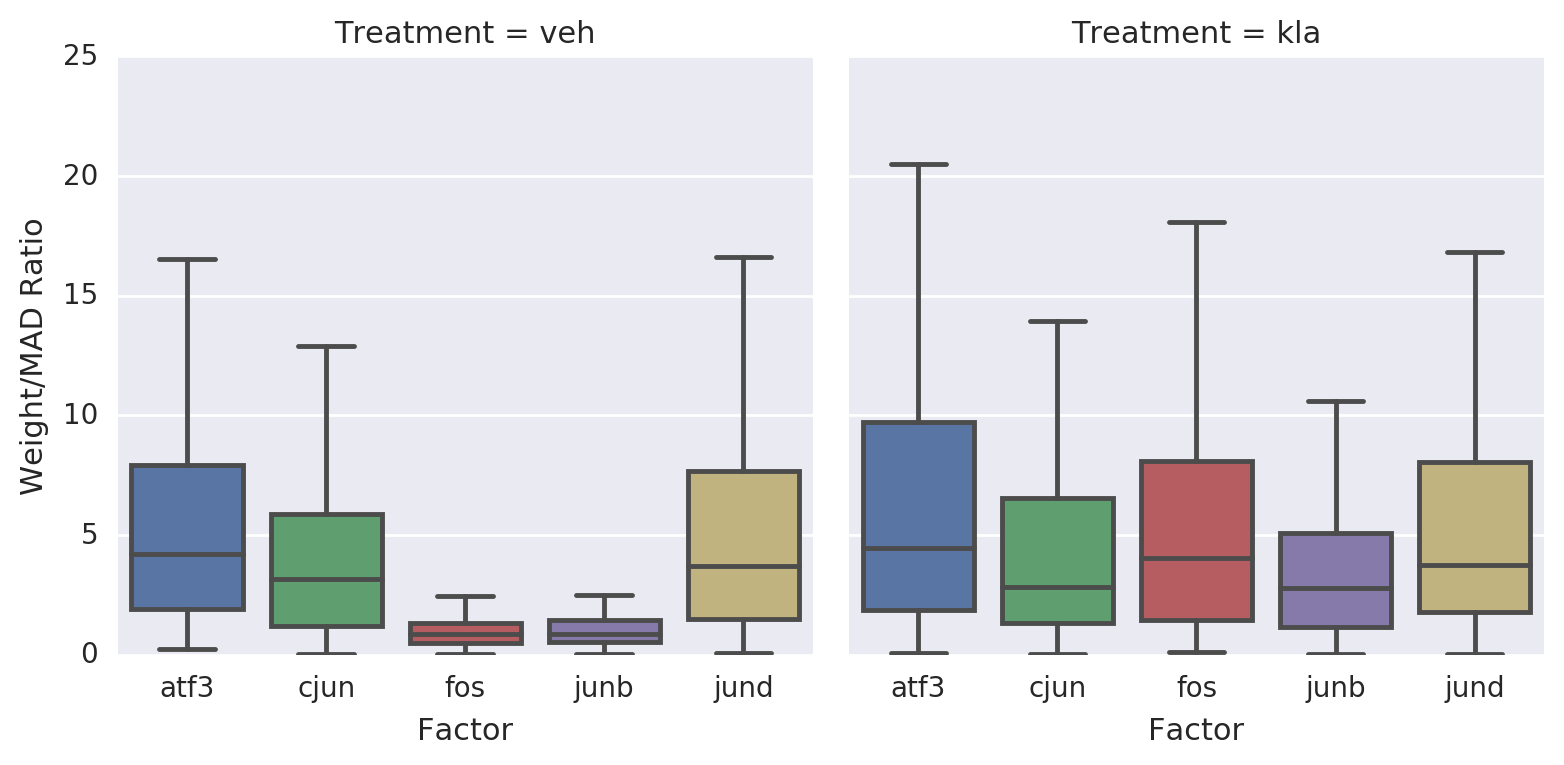

In [356]:
sns.factorplot(data = frame, x = 'Factor', y = 'Weight/MAD Ratio', col='Treatment', kind = 'box', showfliers= False)

### Top Motif

In [336]:
# for monomers using motif counts and best motif score for top motifs
strain = 'c57bl6'
weight_threshold = 1.5
factor_coeff_top_dict = {}
factor_affinityCoeff_top_dict = {}
factor_countCoeff_top_dict = {}

factor_roc_top_dict = {}
factor_affinity_roc_top_dict = {}
factor_count_roc_top_dict = {}

factor_precision_top_dict = {}
factor_affinity_precision_top_dict = {}
factor_count_precision_top_dict = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        # determine top motifs
        data = coefficients_zscore_frame
        top_motifs = data[(data[monomer + '_' + treatment] >= weight_threshold) |
                    (data[monomer + '_' + treatment] < -1 * weight_threshold)
                    ].index.values
        print(len(top_motifs))
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame.index.values
        
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        
        affinity_features = affinity_features[top_motifs]
        count_features = all_standardized_count_frame[top_motifs] 
        
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        results = train_ensemble_classifier(affinity_features, 
                                            count_features, 
                                            labels,
                                            numIterations = numIterations,
                                            test_size = test_size,
                                            )
        
        # unpack result tuples
        # unpack result tuples
        all_rocs = results[0]
        all_affinity_rocs = results[1]
        all_count_rocs = results[2]
        all_precisions = results[3]
        all_affinity_precisions = results[4]
        all_count_precisions = results[5]
        all_coefficients = results[6]
        all_affinity_coefficients = results[7]
        all_count_coefficients = results[8]

        factor_roc_top_dict[monomer + '_' + treatment] = all_rocs
        factor_affinity_roc_top_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_count_roc_top_dict[monomer + '_' + treatment] = all_count_rocs
       
        factor_precision_top_dict[monomer + '_' + treatment] = all_precisions
        factor_affinity_precision_top_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_count_precision_top_dict[monomer + '_' + treatment] = all_count_precisions
    
        factor_coeff_top_dict[monomer + '_' + treatment] = all_coefficients
        factor_affinityCoeff_top_dict[monomer + '_' + treatment] = all_affinity_coefficients
        factor_countCoeff_top_dict[monomer + '_' + treatment] = all_count_coefficients
        
        
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_rocs), np.mean(all_affinity_rocs), np.mean(all_count_rocs),
              'precision:', np.mean(all_precisions), np.mean(all_affinity_precisions), np.mean(all_count_precisions)
             )

14


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.919939794778 0.914122975887 0.793714269547 precision: 0.917467695796 0.91151063251 0.776474166512
13
cjun_veh roc: 0.914709831333 0.911269221993 0.773623646335 precision: 0.915054525935 0.911689272025 0.754002480798
21
fos_veh roc: 0.779578164785 0.773271061124 0.687387154314 precision: 0.793855528251 0.789606689192 0.674446148853
22
junb_veh roc: 0.80465883323 0.798601975225 0.712865201177 precision: 0.831030384 0.82970626109 0.728170743393
14
jund_veh roc: 0.91437652095 0.907146860987 0.774101895704 precision: 0.912642603577 0.906119258843 0.748318769359
13
atf3_kla roc: 0.917642943975 0.912949830798 0.783690386138 precision: 0.912820823156 0.907746845085 0.769194632674
14
cjun_kla roc: 0.928661867393 0.923740388632 0.798173271198 precision: 0.925515859991 0.920880464705 0.777112262825
13
fos_kla roc: 0.930475675614 0.926258335455 0.787649055372 precision: 0.927535543174 0.922825900951 0.768093837052
16
junb_kla roc: 0.944629053293 0.939272601526 0.824356564372 precis

### Polynomial Features

In [337]:
def make_interaction_features(features):
    polynomial_transformer = sklearn.preprocessing.PolynomialFeatures(degree=2, 
                                                                      interaction_only=True)
    interaction_features = pd.DataFrame(polynomial_transformer.fit_transform(features))
    
    # drop first column which is invariant and always 1
    interaction_features = interaction_features.ix[:,1:]  
    
    # fix column names
    motifs = features.columns.values
    interaction_term_columns = list(motifs)
    for i in range(len(motifs)-1):
        for j in range(i+1,len(motifs)):
            interaction_term_columns.append(motifs[i]+'::'+motifs[j])
    interaction_features.columns = interaction_term_columns
    interaction_features.index = features.index.values
    
    return interaction_features

In [338]:
weight_threshold = 1.5
top_veh_motifs = coefficients_zscore_veh_frame[(coefficients_zscore_veh_frame.max(axis=1) >= weight_threshold) |
                                (coefficients_zscore_veh_frame.min(axis=1) < -1 * weight_threshold)
                                ].index.values

top_kla_motifs = coefficients_zscore_kla_frame[(coefficients_zscore_kla_frame.max(axis=1) >= weight_threshold) |
                                (coefficients_zscore_kla_frame.min(axis=1) < -1 * weight_threshold)
                                ].index.values

In [213]:
# for monomers using motif counts and best motif score for polynomial motifs
strain = 'c57bl6'
weight_threshold = 1.5
factor_coeff_interaction_dict = {}
factor_affinityCoeff_interaction_dict = {}
factor_countCoeff_interaction_dict = {}

factor_roc_interaction_dict = {}
factor_affinity_roc_interaction_dict = {}
factor_count_roc_interaction_dict = {}

factor_precision_interaction_dict = {}
factor_affinity_precision_interaction_dict = {}
factor_count_precision_interaction_dict = {}



for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]

        # determine polynomial motifs
        if treatment == 'veh':
            top_motifs = top_veh_motifs
        elif treatment == 'kla':
            top_motifs = top_kla_motifs
        
        target_affinity_features = all_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        # merge target and background features together 
        affinity_features = pd.concat([target_affinity_features, background_affinity_features])
        affinity_features = affinity_features[top_motifs]
        count_features = all_count_frame[top_motifs] 
        print(affinity_features.shape, count_features.shape)
        
        current_interaction_score_features = make_interaction_features(affinity_features)
        current_interaction_count_features = make_interaction_features(count_features)
        print(current_interaction_score_features.shape, current_interaction_count_features.shape)
               
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = affinity_features.index.values)
                
        results = train_ensemble_classifier(current_interaction_score_features, 
                                            current_interaction_count_features, 
                                            labels,
                                            numIterations = numIterations,
                                            test_size = test_size,
                                            )
        
        # unpack result tuples
        all_rocs = results[0]
        all_affinity_rocs = results[1]
        all_count_rocs = results[2]
        all_precisions = results[3]
        all_affinity_precisions = results[4]
        all_count_precisions = results[5]
        all_coefficients = results[6]
        all_affinity_coefficients = results[7]
        all_count_coefficients = results[8]

        factor_roc_interaction_dict[monomer + '_' + treatment] = all_rocs
        factor_affinity_roc_interaction_dict[monomer + '_' + treatment] = all_affinity_rocs
        factor_count_roc_interaction_dict[monomer + '_' + treatment] = all_count_rocs
       
        factor_precision_interaction_dict[monomer + '_' + treatment] = all_precisions
        factor_affinity_precision_interaction_dict[monomer + '_' + treatment] = all_affinity_precisions
        factor_count_precision_interaction_dict[monomer + '_' + treatment] = all_count_precisions
    
        factor_coeff_interaction_dict[monomer + '_' + treatment] = all_coefficients
        factor_affinityCoeff_interaction_dict[monomer + '_' + treatment] = all_affinity_coefficients
        factor_countCoeff_interaction_dict[monomer + '_' + treatment] = all_count_coefficients
        
        
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_rocs), np.mean(all_affinity_rocs), np.mean(all_count_rocs),
              'precision:', np.mean(all_precisions), np.mean(all_affinity_precisions), np.mean(all_count_precisions)
             )
        

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(46272, 16) (1027937, 16)
(46272, 136) (1027937, 136)
atf3_veh roc: 0.935564258978 0.922889985029 0.830977433306 precision: 0.93423463826 0.919175476816 0.830101969071
(31076, 16) (1027937, 16)
(31076, 136) (1027937, 136)
cjun_veh roc: 0.933856362607 0.921187737151 0.829308335731 precision: 0.934263985453 0.919853136713 0.830403514552
(1084, 16) (1027937, 16)
(1084, 136) (1027937, 136)
fos_veh roc: 0.756458926213 0.703837093721 0.685892076633 precision: 0.783040540644 0.744217937941 0.69763873294
(924, 16) (1027937, 16)
(924, 136) (1027937, 136)
junb_veh roc: 0.751989280561 0.722287813197 0.678499278499 precision: 0.758584994122 0.735871896768 0.686578663372
(39248, 16) (1027937, 16)
(39248, 136) (1027937, 136)
jund_veh roc: 0.933370381933 0.918981100706 0.822810042621 precision: 0.931716783372 0.915067199577 0.823163191085
(73432, 19) (1027937, 19)
(73432, 190) (1027937, 190)
atf3_kla roc: 0.935201551342 0.922273493387 0.836246055842 precision: 0.932415377124 0.917280525976 0.83632546

In [ ]:
factor_meanCoeff_interactionAffinity_dict = {}
factor_meanCoeff_interactionCount_dict = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        current_affinity_weights = factor_affinityCoeff_dict[monomer + '_' + treatment]
        current_affinity_weight_frame = pd.DataFrame(current_affinity_weights, 
                                                     ).T
        mean_affinity_weights = current_affinity_weight_frame.mean(axis=1).values
        affinity_weight_mads = current_affinity_weight_frame.mad(axis=1).values
        
        ratios = np.abs(mean_affinity_weights)/ np.abs(affinity_weight_mads)
        
        factor_meanCoeff_affinity_dict[monomer + '_' + treatment] = mean_affinity_weights
        
        treatment_list = treatment_list + [treatment] * len(mean_affinity_weights)
        factor_list = factor_list + [monomer] * len(mean_affinity_weights)
        mad_list = mad_list + list(affinity_weight_mads)
        ratio_list = ratio_list + list(ratios)
        weight_list = weight_list + list(mean_affinity_weights)
        
frame = pd.DataFrame({'Factor':factor_list,
                      'Treatment':treatment_list,
                      'MAD':mad_list,
                      'Weight/MAD Ratio': ratio_list,
                      'Weight':weight_list})
        

### Classifier Performance

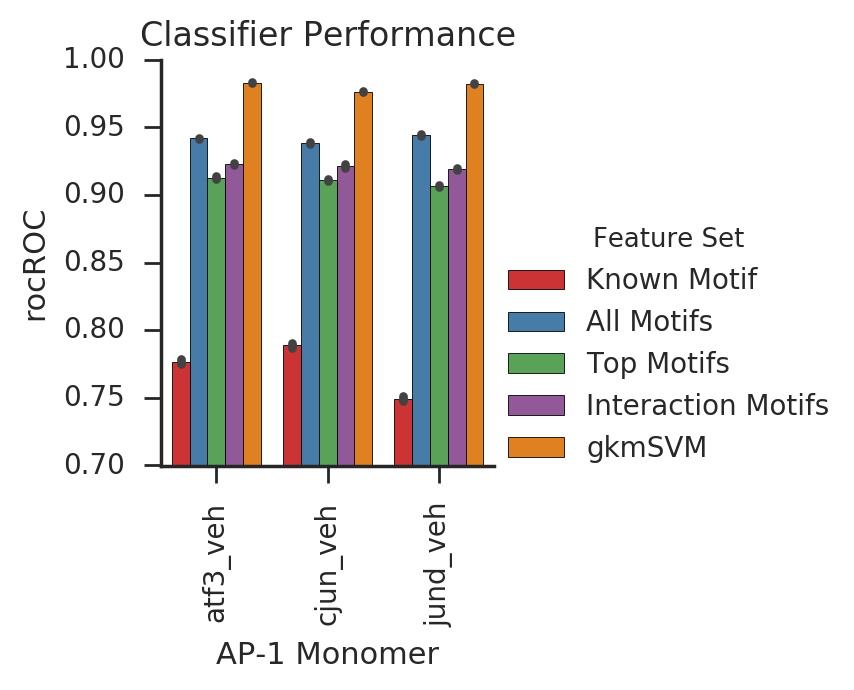

In [250]:
monomers = []
rocs = []
feature_set = []
for factor in ['atf3_veh', 'cjun_veh', 'jund_veh']:
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_ap1Only_dict[factor]
    feature_set = feature_set + numIterations * ['Known Motif']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_dict[factor]
    feature_set = feature_set + numIterations * ['All Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_top_dict[factor]
    feature_set = feature_set + numIterations * ['Top Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_interaction_dict[factor]
    feature_set = feature_set + numIterations * ['Interaction Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_auc_dict_gkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'roc':rocs,
                     'Feature Set': feature_set
                     })

for treatment in ['veh']:
    factor_roc_tuples = [(x, np.mean(factor_roc_dict[x])) for x in factor_roc_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_roc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='roc',
#                                     order = sorted_monomers,
                                    palette='Set1',
                                    size=3,
                                    hue='Feature Set',
                                    kind = 'bar')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('rocROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.7,1)
        plt.title('Classifier Performance')
        plt.savefig('./figures/figure_04_a.svg')
        plt.show()

    

### Distribution of Motif Weights (for cjun-fos, or all dimers?)

In [ ]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    sns.distplot(coefficients_zscore_frame_veh['cjun_veh'])
    sns.despine()
    plt.xlabel('Motif Weight')
    plt.ylabel('Frequency (KDE)')
plt.savefig('./figures/figure_04_b.svg', bbox_inches='tight')

### Scatter plot for similar dimers

In [ ]:
# scatterplot of weights
factor1 = 'cjun_veh'
factor2 = 'jund_veh'
delta_threshold = 2.0
targets = ['ap-1', 'cebp', 'spi1-c']
plt.figure(figsize=(3,3))
motifs = coefficients_zscore_frame_veh.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = coefficients_zscore_frame_veh[factor1]
    y_vals = coefficients_zscore_frame_veh[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15)
    plt.xlabel(factor1.replace('c57bl6_','') + ' Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if (abs(x) >= 0.5) or (abs(y) >= 0.5)  or (motifs[i] in targets):
            delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
            if (delta > delta_threshold) or (motifs[i] in targets):
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.savefig('./figures/figure_04_c.svg', bbox_inches='tight')

### Scatter plot for dissimilar dimers

In [ ]:
# scatterplot of weights
factor1 = 'fos_veh'
factor2 = 'jund_veh'
delta_threshold = 3.0
targets = ['ap-1', 'cebp', 'spi1-c']
plt.figure(figsize=(3,3))
motifs = coefficients_zscore_frame_veh.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = coefficients_zscore_frame_veh[factor1]
    y_vals = coefficients_zscore_frame_veh[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15)
    plt.xlabel(factor1.replace('c57bl6_','') + ' Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if abs(x) >= 0.5 or abs(y) >= 0.5:
            delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
            if delta > delta_threshold or motifs[i] in targets:
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.savefig('./figures/figure_04_d.svg', bbox_inches='tight')


### Heatmap of motif weights

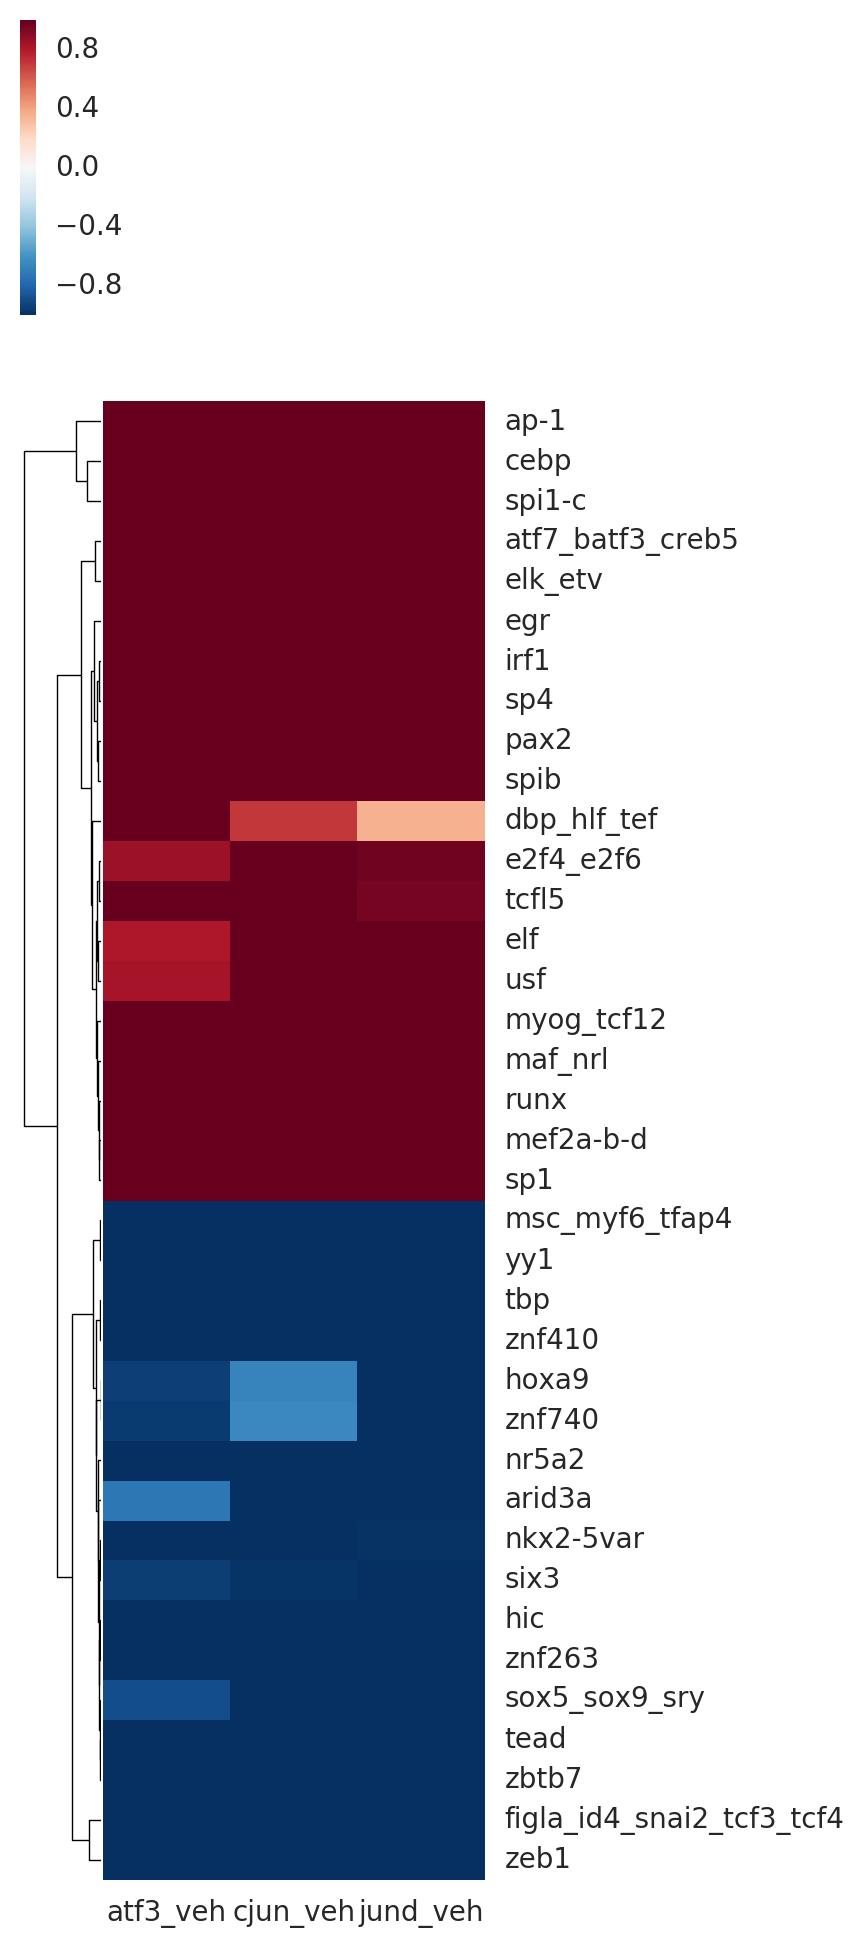

In [327]:
### plot coefficents for vehicle
weight_threshold = 1.0

data = coefficients_zscore_veh_frame[(coefficients_zscore_veh_frame.max(axis=1) >= weight_threshold) |
                                (coefficients_zscore_veh_frame.min(axis=1) < -1 * weight_threshold)
                                ][['atf3_veh', 'cjun_veh', 'jund_veh']]
# data = coefficients_zscore_frame[coefficients_zscore_frame.index.isin(veh_frame.sort('maxDist', ascending=False).index.values[:20])
#                                 ][['atf3_veh', 'cjun_veh', 'jund_veh']]
cg = sns.clustermap(data = data,
                   vmax=-1*weight_threshold,
                   vmin= 1* weight_threshold,
                   center = 0.0,
#                    annot=True,annot_kws={"size": 4},
                   col_cluster = False,
#                    yticklabels=False,
                   figsize=(3,12),
                   )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );
# plt.savefig('./figures/figure_04_e.svg', bbox_inches='tight')

In [136]:
plotting_data = pd.DataFrame(data.stack(), columns= ['Weight'])
index = plotting_data.index.values
plotting_data['Motif'] = [x[0] for x in index]
plotting_data['Monomer'] = [x[1] for x in index]
plotting_data.sort(['Weight'], inplace=True)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]), <a list of 37 Text xticklabel objects>)

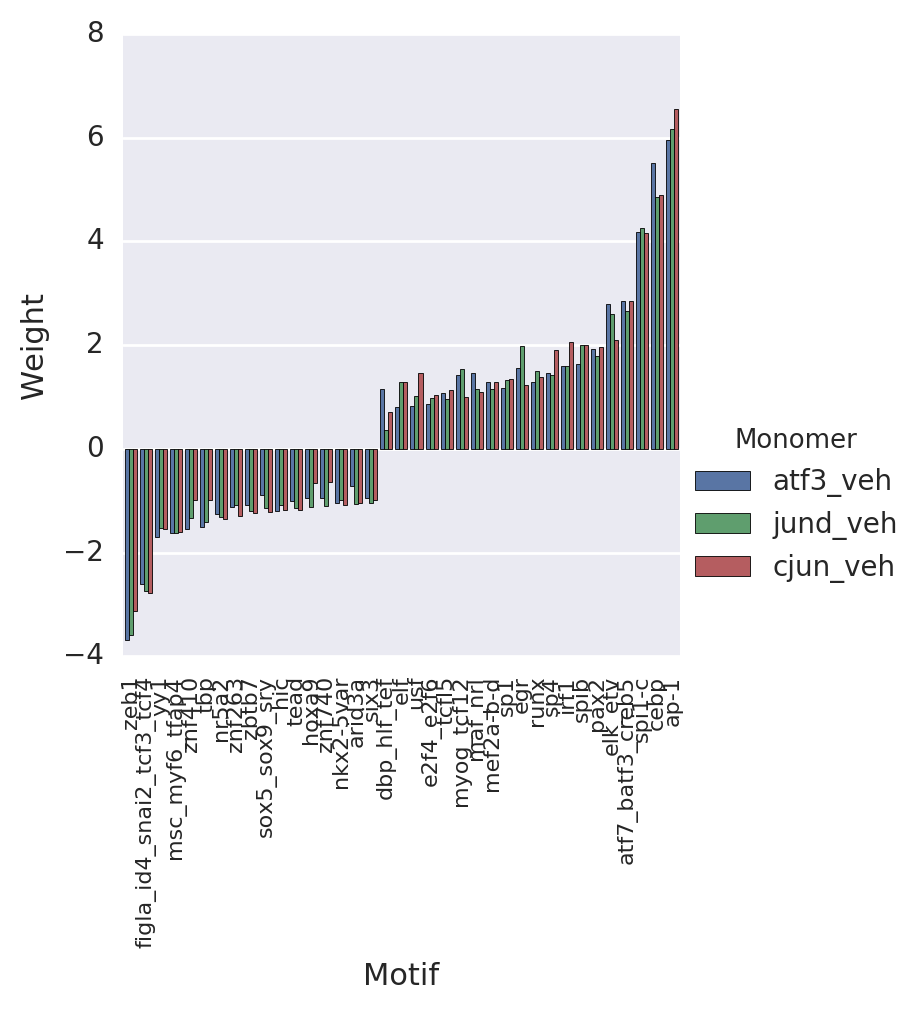

In [137]:
sns.factorplot(data = plotting_data, 
               x = 'Motif', 
               y='Weight', 
               kind = 'bar',
               hue = 'Monomer')
plt.xticks(rotation = 90, size=8)

## Comparison to gkmSVM

In [ ]:
!if [ ! -d ./gkmsvm_files ]; then mkdir ./gkmsvm_files; fi
! rm ./gkmsvm_files/*

In [ ]:
### read in target sequences as dictionary {peakID: sequence}
with open('./peak_sequences/C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  
### read in background sequences
with open('./C57BL6J_background.fa') as f:
    data = f.readlines()

for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

In [ ]:
### for all peaks in vehicle using gapped k-mers on background data
### write script
background_ratio = 5.0
numIterations = 5
for treatment in ['veh', 'kla']:
    script_file = open('gkmsvm_' + treatment + '.sh', 'w')
    for monomer in factors:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame.index.values
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_split(
                    features, labels, test_size = test_size)

                # create fasta files for positive and negative sequences
                training_positive_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_positive_' +str(iteration) + '.fa'
                training_negative_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_negative_' +str(iteration) + '.fa'

                training_positive_file = open(training_positive_path,'w' )
                training_negative_file = open(training_negative_path,'w' )
                test_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_test_' + str(iteration) + '.fa'

                test_file = open(test_path,'w')

                numPositiveSeqs = np.sum(training_labels)
                count=0
                for i in range(len(training_labels)):
                    index = training_labels.index[i]
                    label = training_labels[i]
                    seq = _id_sequence_dict[index]

                    if label == True:
                        training_positive_file.write('>' + index + '\n')
                        training_positive_file.write(seq + '\n')
                    else:
                        training_negative_file.write('>' + index + '\n')
                        training_negative_file.write(seq + '\n')
                        count+=1

                for i in range(len(test_labels)):
                    index = test_labels.index[i]
                    label = test_labels[i]
                    seq = _id_sequence_dict[index]
                    test_file.write('>' + index + '\n')
                    test_file.write(seq + '\n')

                training_positive_file.close()
                training_negative_file.close()
                test_file.close()

                #  Run classifier
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration)
                model_path = model_prefix + '.model.txt'
                results_path = model_prefix + '_results.txt'

                script_file.write('(gkmtrain '+ training_positive_path + ' ' + training_negative_path + ' ' + model_prefix +
                          ' -T 16 -m 64000;')
                if iteration == (numIterations - 1):
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)\n')
                else:
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)&\n')
                

    script_file.close()

In [ ]:
%%bash
chmod a+x ./gkmsvm_veh_background.sh 
./gkmsvm_veh.sh

In [ ]:
%%bash
chmod a+x ./gkmsvm_kla_background.sh 
./gkmsvm_kla.sh

In [ ]:
### for all peaks in vehicle using gapped k-mers on background data
### read performance
factor_auc_dict_gkmSVM = {}
factor_precision_dict_gkmSVM = {}

for treatment in ['veh', 'kla']:
    for monomer in factors:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame.index.values

        target_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_affinity_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_affinity_features, background_affinity_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                model_prefix = './gkmsvm_files/' + monomer  + '_' + treatment+ '_' +str(iteration)
                results_path = model_prefix + '_results.txt'


                index_score_dict = {} #{peakID: gkmSVM score}
                with open(results_path) as f:
                    data = f.readlines()
                for line in data:
                    tokens=line.strip().split()
                    score = float(tokens[1])
                    index = tokens[0]
                    index_score_dict[index] = score
                # define true labels
                index_label_dict = dict(zip(labels.index.values, labels.values))

                sorted_indices = sorted(index_score_dict.keys())

                sorted_scores = np.array([index_score_dict[x] for x in sorted_indices])
                test_labels = np.array([index_label_dict[x] for x in sorted_indices])

                min_score = np.min(sorted_scores)
                if min_score < 0:
                    normalized_scores = sorted_scores + abs(min_score)
                normalized_scores = normalized_scores/np.max(normalized_scores)

                # score predictions          
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
                all_precisions.append(current_precision)
                all_aucs.append(current_roc_auc)

            # average scoring metrics 

            mean_roc_auc = np.mean(all_aucs) 
            mean_precision = np.mean(all_precisions)

            factor_auc_dict_gkmSVM[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_gkmSVM[monomer + '_' + treatment]= all_precisions

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )

# Figure 5 - Context Change after KLA treatment

In [ ]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']

### Classifier Performance

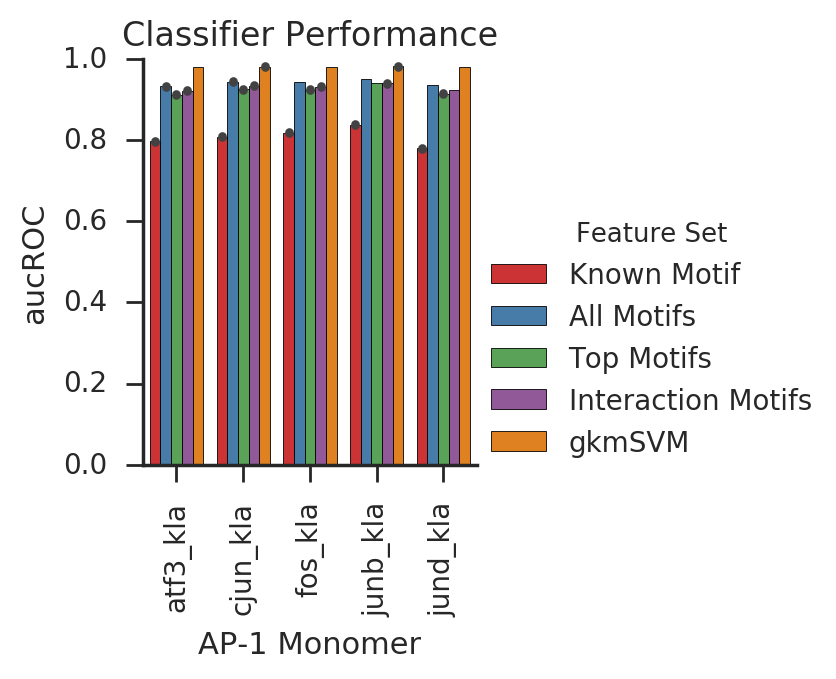

In [251]:
monomers = []
rocs = []
feature_set = []
for factor in ['atf3_kla','cjun_kla', 'fos_kla', 'junb_kla','jund_kla']:
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_ap1Only_dict[factor]
    feature_set = feature_set + numIterations * ['Known Motif']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_dict[factor]
    feature_set = feature_set + numIterations * ['All Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_top_dict[factor]
    feature_set = feature_set + numIterations * ['Top Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_affinity_roc_interaction_dict[factor]
    feature_set = feature_set + numIterations * ['Interaction Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_auc_dict_gkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'roc':rocs,
                     'Feature Set': feature_set
                     })

for treatment in ['kla']:
    factor_roc_tuples = [(x, np.mean(factor_roc_dict[x])) for x in factor_roc_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_roc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='roc',
#                                     order = sorted_monomers,
                                    palette='Set1',
                                    size=3,
                                    hue='Feature Set',
                                    kind = 'bar')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.0,1)
        plt.title('Classifier Performance')
        plt.savefig('./figures/figure_05_a.svg')
        plt.show()

    

### Scatter plot for all cjun-jund motif weights before and after Vehicle

In [284]:
differences_frame = pd.DataFrame(coefficients_zscore_kla_frame[['atf3_kla', 'cjun_kla', 'jund_kla']].values - coefficients_zscore_veh_frame.values)
differences_frame.columns = ['atf3', 'cjun', 'jund']
differences_frame.index = coefficients_zscore_kla_frame.index.values

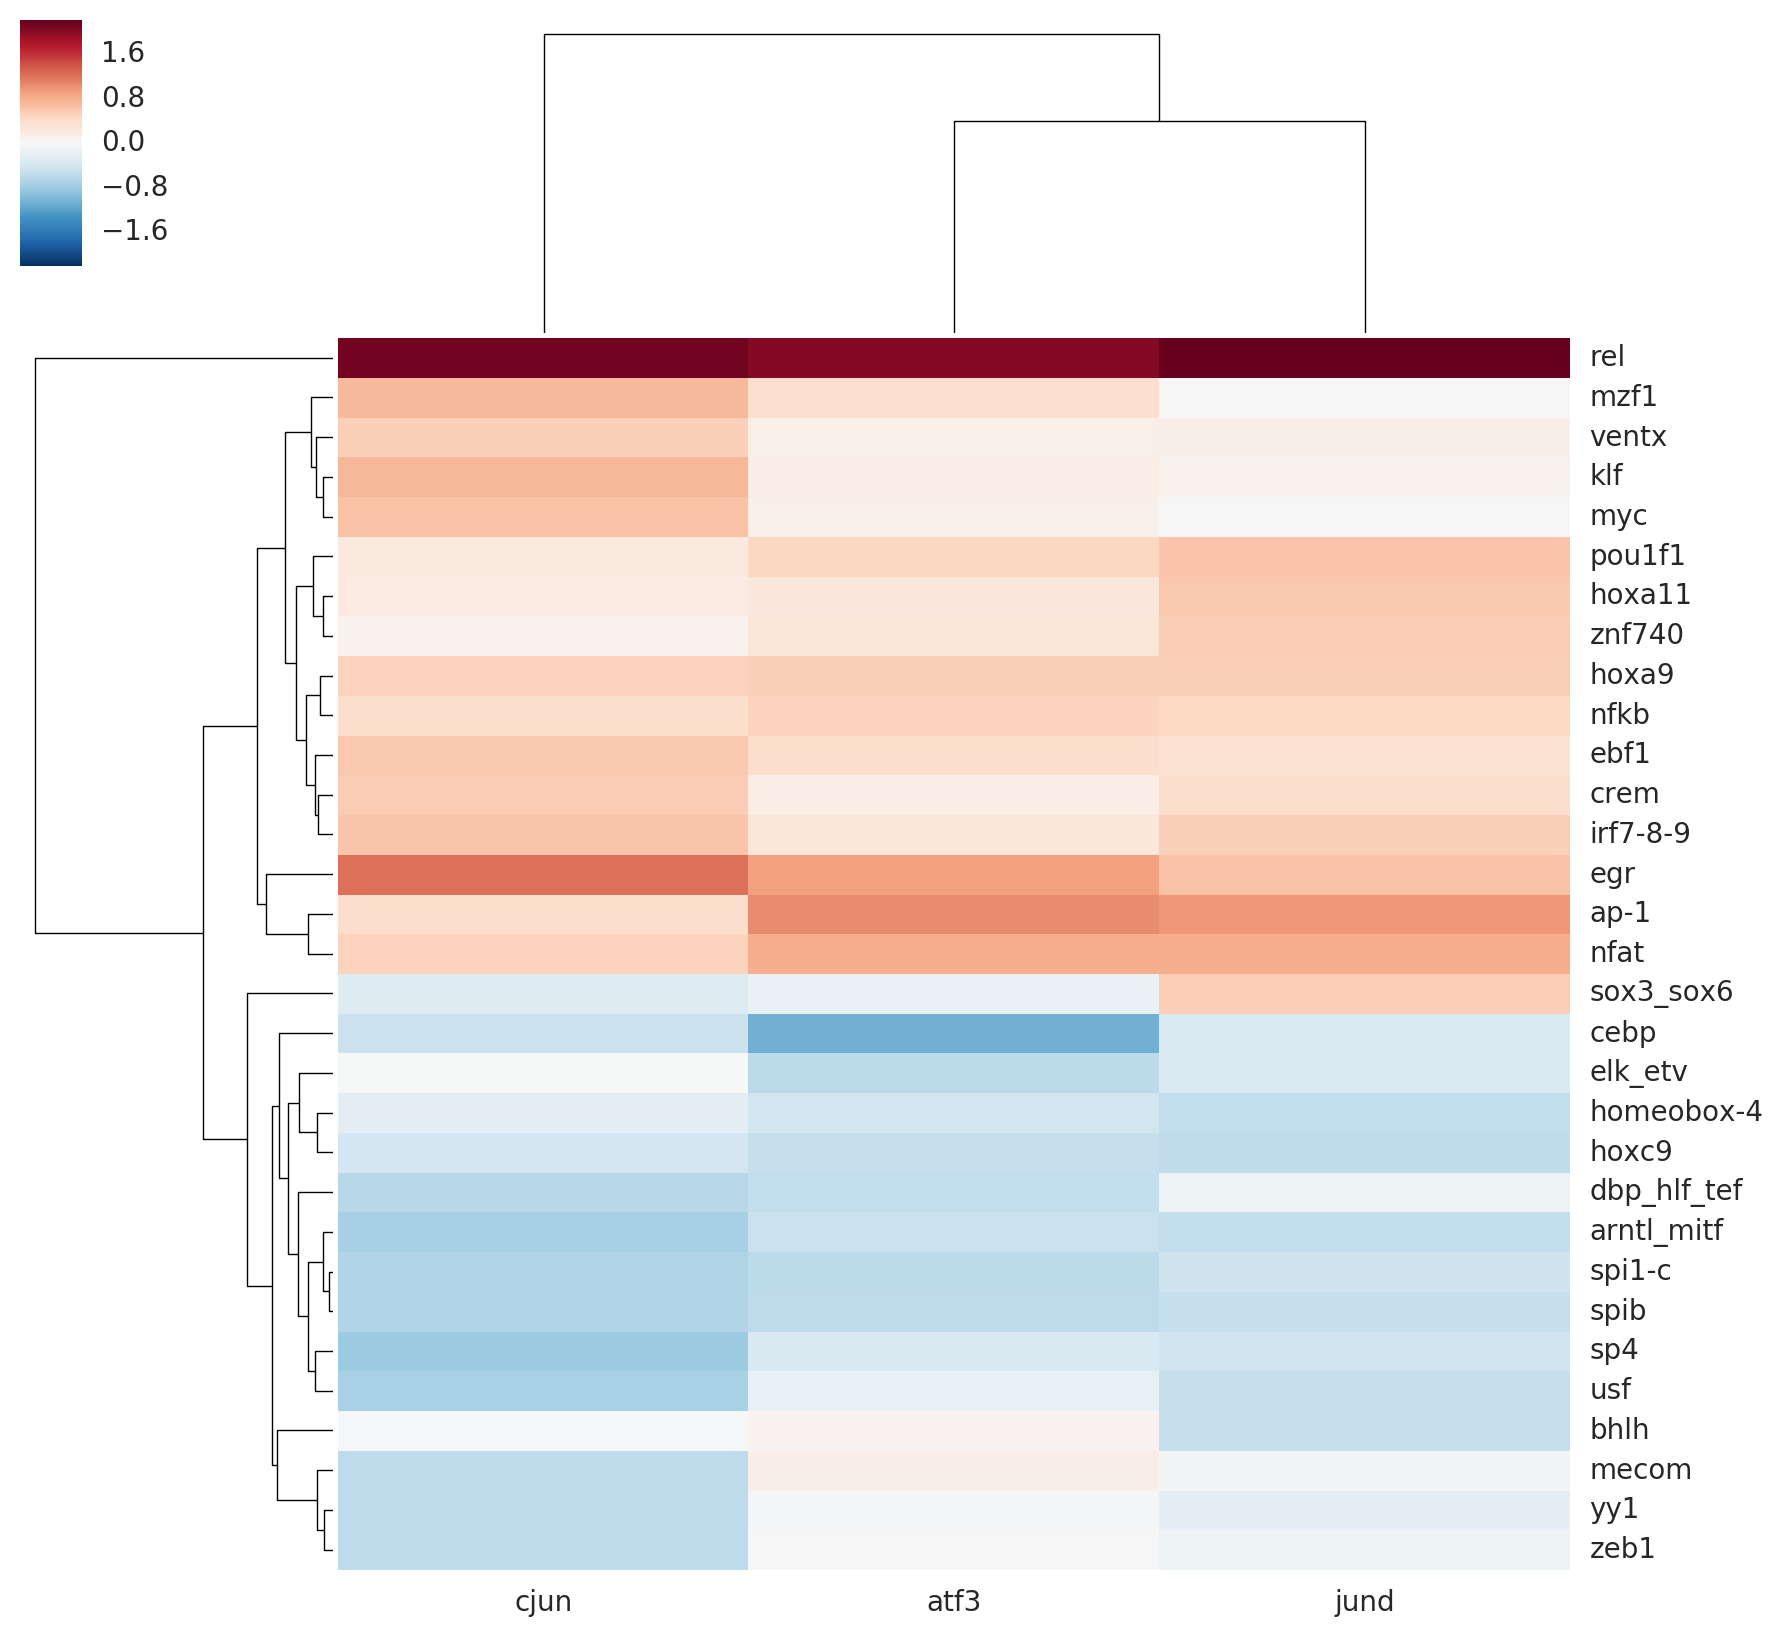

In [300]:
cg = sns.clustermap(differences_frame[differences_frame.abs().max(axis=1) >=0.50], yticklabels=True)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);


In [293]:
differences_frame.sort('jund', ascending = False)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,atf3,cjun,jund
rel,2.029569,2.125458,2.209448
ap-1,1.035946,0.384828,0.978368
nfat,0.804933,0.506572,0.809522
egr,0.911840,1.212221,0.651130
pou1f1,0.482641,0.213603,0.636477
hoxa11,0.252588,0.198525,0.599416
znf740,0.271303,0.076963,0.565417
sox3_sox6,-0.141376,-0.290665,0.545164
hoxa9,0.527958,0.514508,0.533029
irf7-8-9,0.269454,0.615445,0.519651


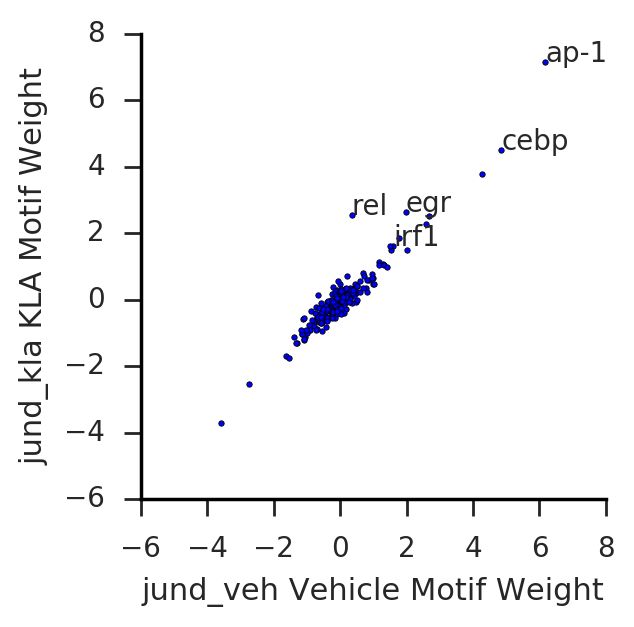

In [274]:
# scatterplot of weights
factor1 = 'jund_veh'
factor2 = 'jund_kla'
delta_threshold = 1.0
targets = ['ap-1', 'cebp', 'rel', 'egr', 'irf1']
# targets = []
plt.figure(figsize=(3,3))
motifs = coefficients_zscore_veh_frame.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = coefficients_zscore_veh_frame[factor1]
    y_vals = coefficients_zscore_kla_frame[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15)
    plt.xlabel(factor1.replace('c57bl6_','') + ' Vehicle Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' KLA Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if abs(x) >= 0.5 or abs(y) >= 0.5:
            delta = np.max([y_vals[i], x_vals[i]]) - np.min([y_vals[i], x_vals[i]])
            if abs(delta) > delta_threshold or motifs[i] in targets:
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
plt.savefig('./figures/figure_05_b.svg', bbox_inches='tight')


### Heatmap for all KLA dimer weights

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


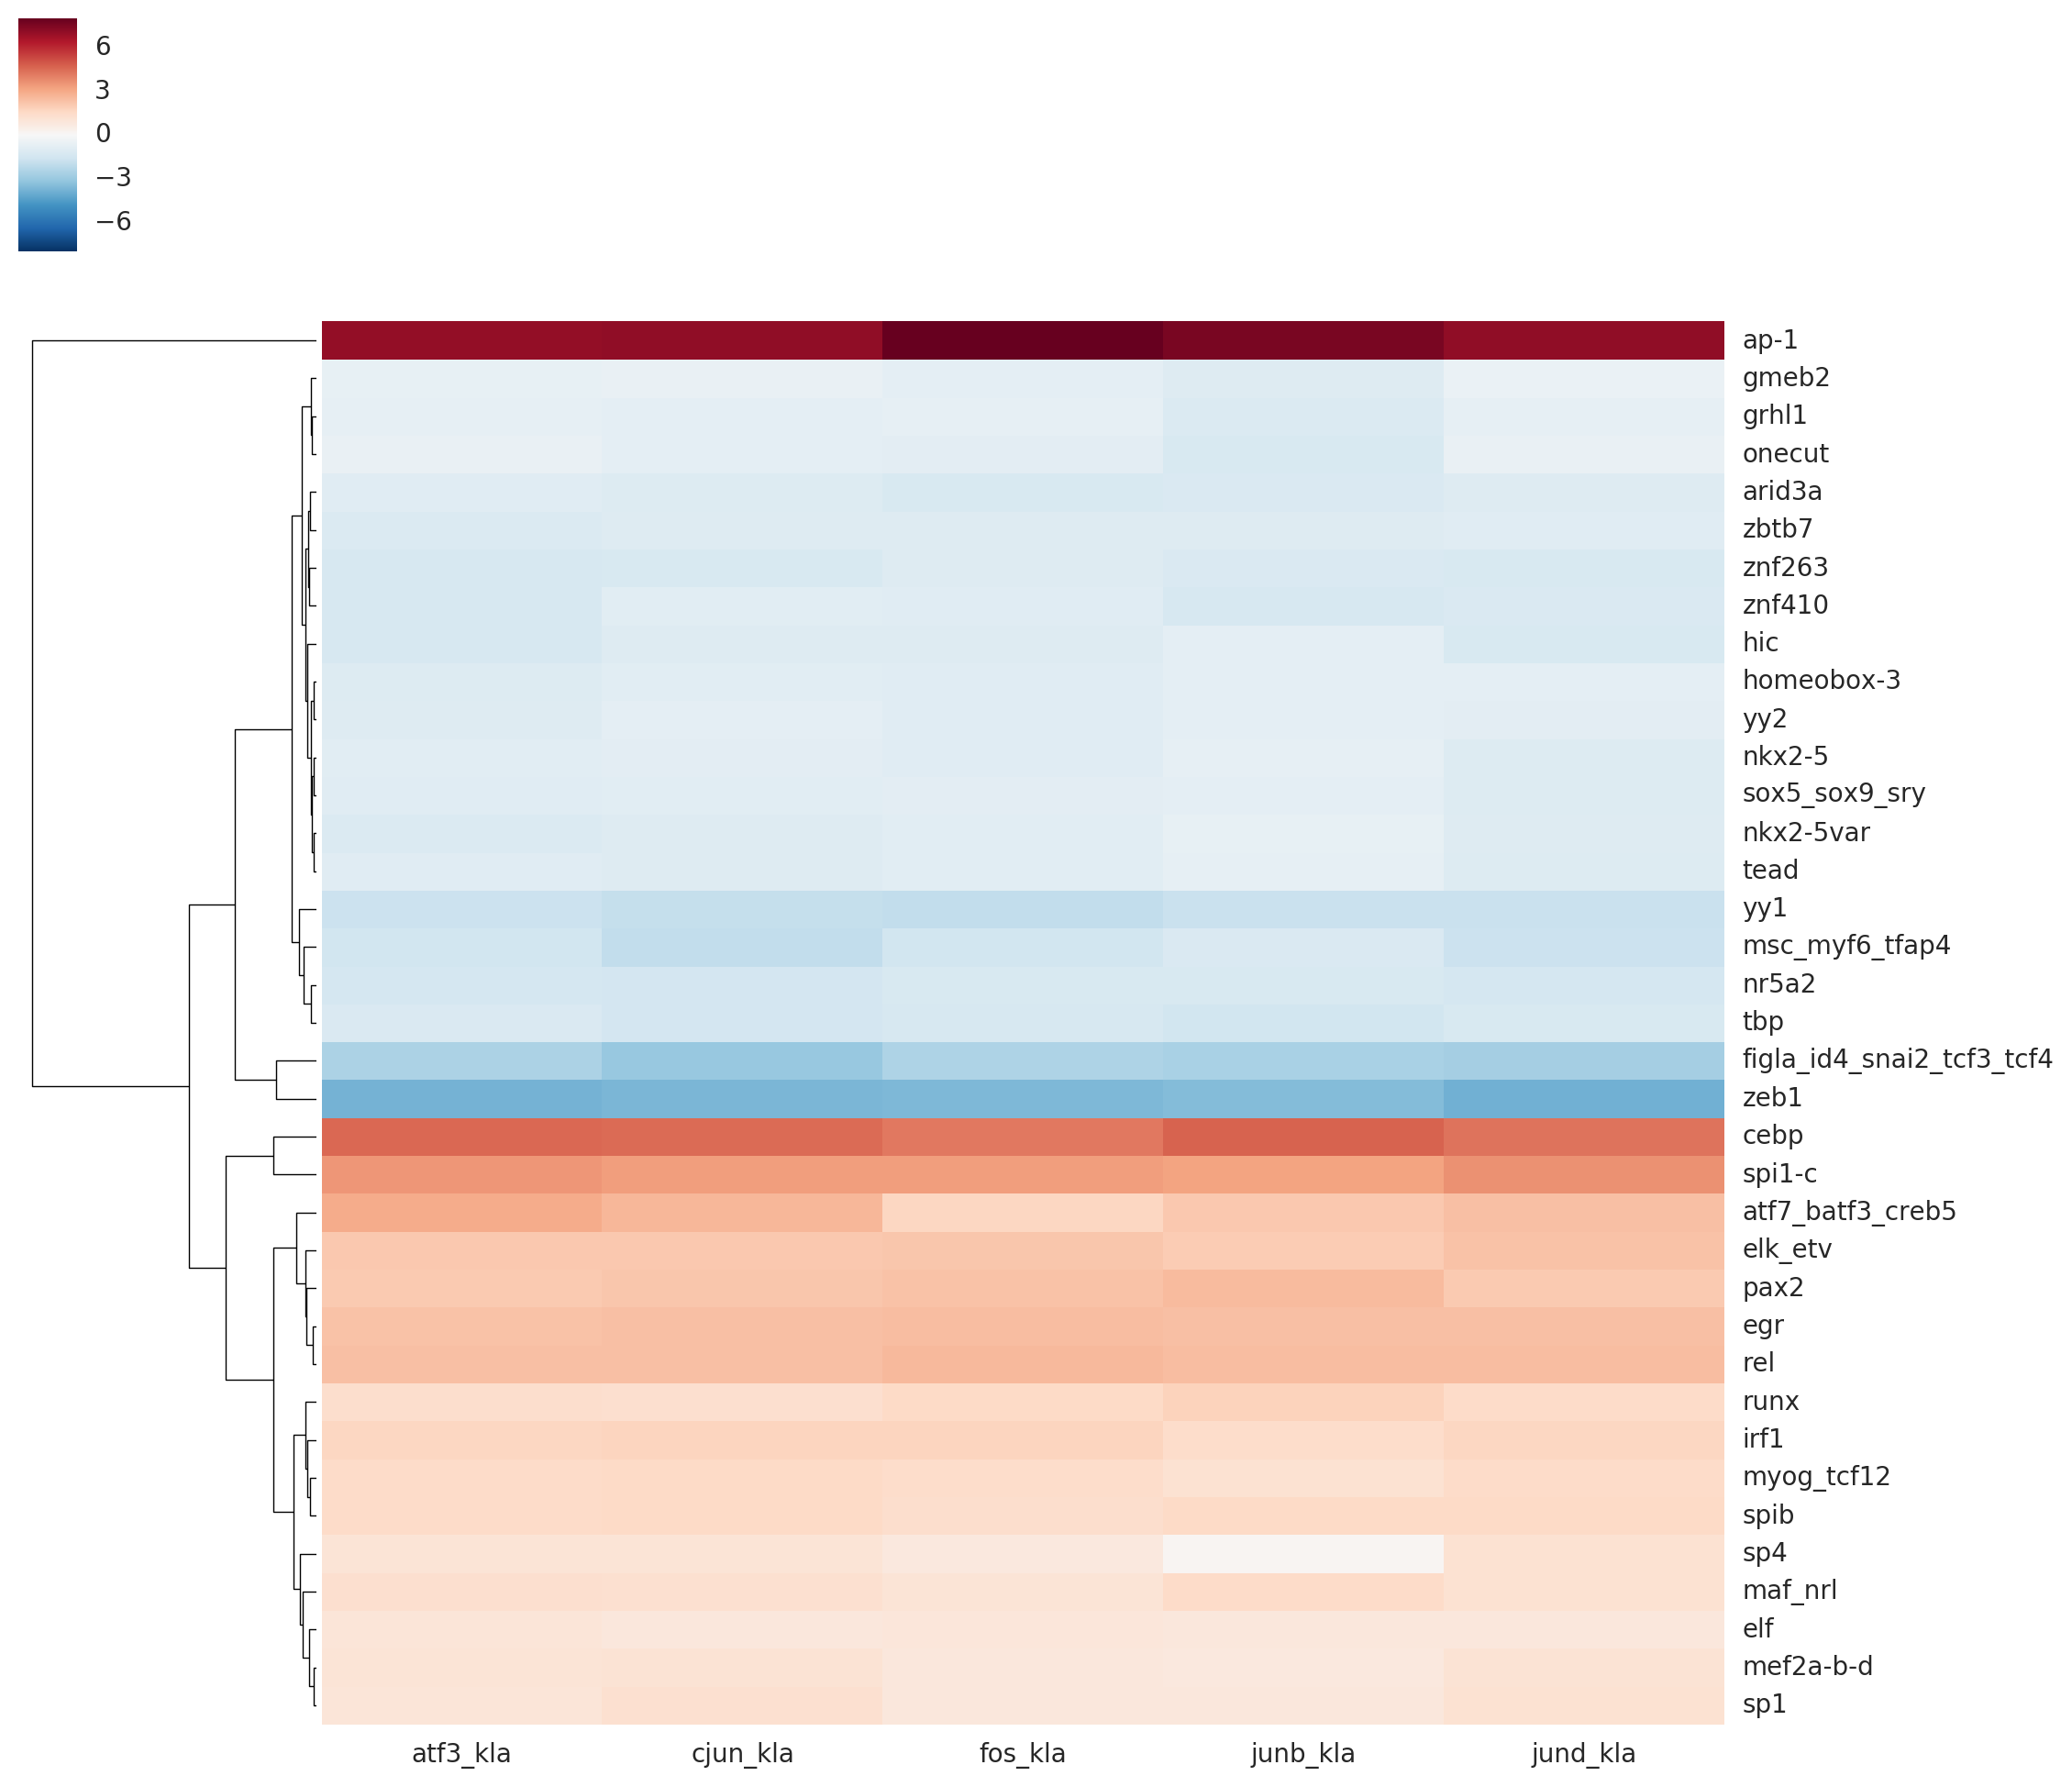

In [132]:
### plot coefficents for kla
weight_threshold = 1.0

cg = sns.clustermap(coefficients_zscore_kla_frame[(coefficients_zscore_kla_frame.max(axis=1) >= weight_threshold) |
                                       (coefficients_zscore_kla_frame.min(axis=1) < -1 * weight_threshold)
                                      ],
#                    vmax= -1 * weight_threshold,
#                    vmin= 1 * weight_threshold,
                    col_cluster=False,
                   center = 0.0,
#                    annot=True,annot_kws={"size": 4},
                   figsize=(12,12),
                   xticklabels=[x.replace('c57bl6_','') for x in coefficients_zscore_kla_frame.columns.values])
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
# plt.savefig('./figures/figure_05_c.svg', bbox_inches='tight')

In [ ]:
with sns.axes_style('ticks'):
    sns.pairplot(coefficients_zscore_kla_frame,
                markers = '.',
                 
                plot_kws={'edgecolors':'none'},
                aspect=1.0)

### Barplots showing inducible RNA-seq expression for significant motifs that are different between vehicle and KLA

In [258]:
# read in rpkm values
rpkm_frame = pd.read_csv('./rpkm_untreated.tsv', sep='\t')

rpkm_frame.index = [x.split('|')[0].upper() for x in rpkm_frame['Annotation/Divergence']]
rpkm_frame = rpkm_frame.ix[:,8:]
rpkm_frame.columns = [x.split('/')[-2].split('_')[3] for x in rpkm_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Treatment'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

In [259]:
difference_threshold = 2.0
motifs = coefficients_zscore_frame_veh.index.values
for fp in coefficients_zscore_frame_veh.columns.values:
    differences = coefficients_zscore_frame_kla[fp.replace('veh','kla')] - coefficients_zscore_frame_veh[fp]
    signs = coefficients_zscore_frame_kla[fp.replace('veh','kla')] * coefficients_zscore_frame_veh[fp]
    print('***', fp.replace('c57bl6_',''))
    for i in range(len(differences)):
        if abs(differences[i]) > difference_threshold:
            print('   ',motifs[i], differences[i])


NameError: name 'coefficients_zscore_frame_veh' is not defined

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

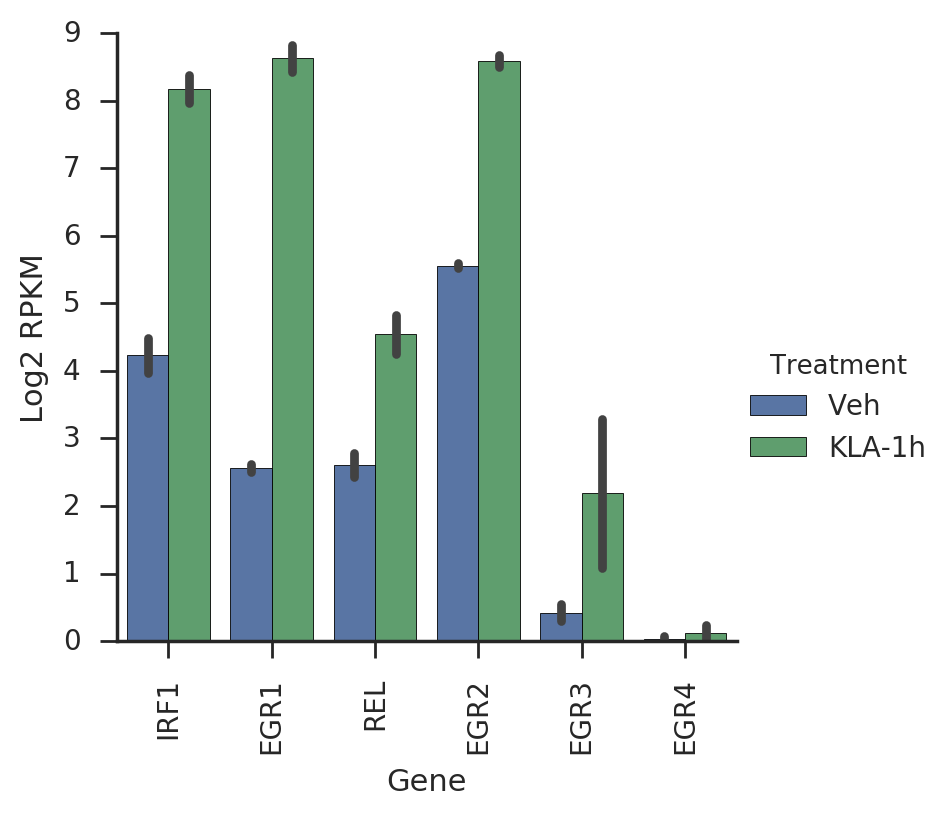

In [310]:
gene_list = ['REL', 'EGR1', 'ESR1', 'ESR2', 'RXRA', 'RXRB', 'IRF1', 'IRF7', 'IRF8', 'IRF9']
gene_list = ['IRF1', 'EGR1', 'REL', 'EGR2', 'EGR3', 'EGR4']#, 'RXRA', 'RXRB','PPARG','NR1H2']


plottingFrame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, x='Gene', y='Log2 RPKM', hue='Treatment', kind='bar', 
                   order = gene_list,
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)

plt.xticks(rotation=90)


# Figure 6 - Strains Based Confirmation

### Run Verena's scripts

In [ ]:
! if [ ! -d ./marge_files ]; then mkdir ./marge_files; fi
! if [ ! -d ./marge_output ]; then mkdir ./marge_output; fi

In [ ]:
# read in best samples for use with annotation
# for c57bl6 samples
with open ('/home/jtao/analysis/ap1_analysis/best_samples.tsv') as f:
    data = f.readlines()
condition_samples_dict = {}
for line in data:
    tokens = line.strip().split('\t')
    condition = '_'.join(tokens[:3])
    samples = tokens[3:-1]
    condition_samples_dict[condition] = samples
    
# for nod and balbc
with open ('/home/jtao/analysis/ap1_analysis/best_samples_strains.tsv') as f:
    data = f.readlines()
for line in data:
    tokens = line.strip().split('\t')
    condition = '_'.join(tokens[:3])
    samples = tokens[3:-1]
    condition_samples_dict[condition] = samples

In [ ]:
strain_fullStrain_dict ={'balbc':'BALBCJ','c57bl6':'C57BL6J', 'nod':'NODSHILTJ'}

In [ ]:
c57bl6_path = '/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/'
strains_path = '/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/'
# create peak files for each dimer
### create peak files for denovo motif
peak_threshold = 50 # minimum number of peaks required for running motif analysis
factors = ['atf3', 'cjun', 'fos','junb', 'jund']
strains = ['balbc','c57bl6']
for strain in strains:
    for treatment in ['veh', 'kla']:
        for i in range(len(factors) - 1):
            factor1 = strain + '_'+factors[i] + '_' + treatment

            if factor1 in summary_frame.columns:
                outputPath = './marge_files/' + strain + '_' + factors[i] +'_' +treatment+ '_peaks.tsv'

                current_frame = summary_frame[(summary_frame[factor1]> 0)]

                current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
                current_peak_frame['strand'] = '+'
                columns = current_peak_frame.columns.values
                columns[0]='#PeakID'
                current_peak_frame.columns = columns
                if not os.path.isfile(outputPath):
                    if current_peak_frame.shape[0]  > peak_threshold:
                        current_peak_frame.to_csv(outputPath,
                                                 index=False,
                                                 sep='\t')
# create merged peak files for each pair of strains
for treatment in ['veh', 'kla']:
    for i in range(len(factors) - 1):
        factor1 = factors[i]

        for k in range(len(strains)-1):
            strain1 = strains[k]
            for l in range(k+1, len(strains)):
                strain2 = strains[l]
                strain1_path = './marge_files/' + '_'.join([strain1, factor1, treatment, 'peaks.tsv'])
                strain2_path = './marge_files/' + '_'.join([strain2, factor1, treatment, 'peaks.tsv'])

                if os.path.isfile(strain1_path) and os.path.isfile(strain2_path):
                    merged_file_path = './marge_files/' + '_'.join([strain1, strain2, factor1, treatment, 'mergedPeaks.tsv'])
                    if not os.path.isfile(merged_file_path):
                        print('mergePeaks -d given ' + strain1_path + ' ' + strain2_path + '>' + merged_file_path)
                        os.system('mergePeaks -d given ' + strain1_path + ' ' + strain2_path + '>' + merged_file_path)

                    # annotate merged peak files with best tag directories
                    strain1_samples = condition_samples_dict[strain1 + '_' + factor1 + '_'+treatment]
                    strain2_samples = condition_samples_dict[strain2 + '_' + factor1 + '_'+treatment]

                    strain1_samples = [c57bl6_path + x if 'C57' in x else strains_path + x for x in strain1_samples]
                    strain2_samples = [c57bl6_path + x if 'C57' in x else strains_path + x for x in strain2_samples]
                    annotated_file_path = merged_file_path.replace('merged','annotated')
                    if not os.path.isfile(annotated_file_path):
                        print('annotatePeaks.pl '+ merged_file_path + ' mm10 -noann -nogene -d ' + 
                              ' '.join(strain1_samples + strain2_samples) + '>' + annotated_file_path)
                        os.system('annotatePeaks.pl '+ merged_file_path + ' mm10 -noann -nogene -d ' + 
                              ' '.join(strain1_samples + strain2_samples) + '>' + annotated_file_path)
                    strain1_conditions = [strain1 + '_' + x.split('/')[-1].split('_')[3] for x in strain1_samples]
                    strain2_conditions = [strain2 + '_' + x.split('/')[-1].split('_')[3] for x in strain2_samples]


                    # average tag counts from tag directories
                    averaged_file_path = annotated_file_path.replace(strain1, 'avg_'+strain1)
                    if not os.path.isfile(averaged_file_path):
                        print('/gpfs/data01/glasslab/home/vlink/code/average_tag_counts.pl ' +
                                 annotated_file_path + ' ' + ' '.join(strain1_conditions + strain2_conditions))
                        os.system('/gpfs/data01/glasslab/home/vlink/code/average_tag_counts.pl ' +
                                 annotated_file_path + ' ' + ' '.join(strain1_conditions + strain2_conditions))

                    # sum up tag counts from both monomers
                    summed_file_path = annotated_file_path.replace('annotated','summed')
                    if not os.path.isfile(summed_file_path):
                        averaged_frame = pd.read_csv(averaged_file_path,sep='\t')
                        summed_frame = averaged_frame.ix[:,:7]
                        summed_frame[strain1] = np.sum(averaged_frame[[x for x in averaged_frame.columns if strain1 in x and 'avg'in x]], axis=1)
                        summed_frame[strain2] = np.sum(averaged_frame[[x for x in averaged_frame.columns if strain2 in x and 'avg'in x]], axis=1)
                        summed_frame.to_csv(summed_file_path, sep='\t', index=False)
#                         # call mutation analysis script
                    print('/home/vlink/mouse_strains/marge/analysis/analyze_ChIP_mutations_tree.pl '+
                          '-genome mm10 -strains ' + strain_fullStrain_dict[strain1] + ', ' + strain_fullStrain_dict[strain2] +
                          ' -file ' + summed_file_path + ' -AB ap-1 -output ' + '_'.join([strain1, strain2, factor1, treatment]) +
                          ' -plots plot_' + '_'.join([strain1, strain2, factor1,  treatment]))

                    os.system('/home/vlink/mouse_strains/marge/analysis/analyze_ChIP_mutations_tree.pl '+
                          '-genome mm10 -strains ' + strain_fullStrain_dict[strain1] + ', ' + strain_fullStrain_dict[strain2] +
                          ' -file ' + summed_file_path + ' -AB ap-1 -output ./marge_output/' + '_'.join([strain1, strain2, factor1, treatment]) +
                          ' -plots ./marge_output/plot_' + '_'.join([strain1, strain2, factor1,  treatment]))

      



# Figure 7 - Validation Experiment

# Figure 8 - RNA-seq and GRO-seq

### Scatter plot for jun knockdown (wt-veh vs siJun-veh)

### Scatter plot for jun knockdown (wt-KLA vs siJun-KLA)

### Scatter plot comparing two knockdowns (siATF3 vs siJun veh)

### GO analysis for knockdowns as a heatmap

### GRO-seq fold change plot for AP-1 dimers

In [ ]:
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factorPairs = []
# ap1_members = ['atf3','cjun', 'fos', 'fra1','fra2', 'jdp2', 'junb','jund']    
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    


for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

In [ ]:
# get peak IDS for peaks

reads = []
factors = []
treatments = []
fold_changes = []
for treatment in ['Veh','KLA', 'Both']:
    for fp in factorPairs:
        factor_auc_dict = {}
        factor1 = fp[0] + '_' + treatment.lower()
        factor2 = fp[1] + '_' + treatment.lower()
        
        if treatment == 'Veh':
            indices1 = set(intergenic_summary_frame[(intergenic_summary_frame[factor1] > 0) &
                                                   (intergenic_summary_frame[factor1.replace('veh','kla')] == 0)].index.values)
            indices2 = set(intergenic_summary_frame[(intergenic_summary_frame[factor2] > 0) &
                                                   (intergenic_summary_frame[factor2.replace('veh','kla')] == 0)].index.values)
        elif treatment == 'KLA':
            indices1 = set(intergenic_summary_frame[(intergenic_summary_frame[factor1] > 0) &
                                                   (intergenic_summary_frame[factor1.replace('kla','veh')] == 0)].index.values)
            indices2 = set(intergenic_summary_frame[(intergenic_summary_frame[factor2] > 0) &
                                                   (intergenic_summary_frame[factor2.replace('kla','veh')] == 0)].index.values)


        else:
            indices1 = set(intergenic_summary_frame[(intergenic_summary_frame[factor1.replace('both','veh')] > 0) &
                                                   (intergenic_summary_frame[factor1.replace('both','kla')] > 0)].index.values)
            indices2 = set(intergenic_summary_frame[(intergenic_summary_frame[factor2.replace('both','veh')] > 0) &
                                                   (intergenic_summary_frame[factor2.replace('both','kla')] > 0)].index.values)

            
        indices = indices1.intersection(indices2)
        if not treatment == 'Both':
            gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
                [['Gro_'+ treatment +' +', 'Gro_'+treatment+ ' -']].sum(axis=1)
        else:
            gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
                [['Gro_Veh +', 'Gro_Veh -', 'Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
        veh_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
            [['Gro_Veh +', 'Gro_Veh -']].sum(axis=1)
        kla_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
            [['Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
        
        factors = factors + [' '.join(fp).replace('c57bl6_','')] * len(gro_reads)
        treatments = treatments + [treatment] * len(gro_reads)
        reads = reads + list(gro_reads)
        fold_changes = fold_changes + list((kla_reads + 0.1)/(veh_reads + 0.1))




In [ ]:
# # get peak IDS for peaks

# reads = []
# factors = []
# treatments = []
# fold_changes = []
# for treatment in ['Veh','KLA', 'Both']:
#     for monomer in ap1_members:       
#         if treatment == 'Veh':
#             indices = set(intergenic_summary_frame[(intergenic_summary_frame['c57bl6_' + monomer + '_veh'] > 0) &
#                                                    (intergenic_summary_frame['c57bl6_' + monomer + '_kla'] == 0)].index.values)
#         elif treatment == 'KLA':
#             indices = set(intergenic_summary_frame[(intergenic_summary_frame['c57bl6_' + monomer + '_kla'] > 0) &
#                                                    (intergenic_summary_frame['c57bl6_' + monomer + '_veh'] == 0)].index.values)

#         else:
#             indices = set(intergenic_summary_frame[(intergenic_summary_frame['c57bl6_' + monomer + '_veh'] > 0) &
#                                                    (intergenic_summary_frame['c57bl6_' + monomer + '_kla'] > 0)].index.values)
#         if not treatment == 'Both':
#             gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
#                 [['Gro_'+ treatment +' +', 'Gro_'+treatment+ ' -']].sum(axis=1)
#         else:
#             gro_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
#                 [['Gro_Veh +', 'Gro_Veh -', 'Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
#         veh_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
#             [['Gro_Veh +', 'Gro_Veh -']].sum(axis=1)
#         kla_reads = intergenic_annotation_frame[intergenic_annotation_frame.index.isin(indices)]\
#             [['Gro_KLA +', 'Gro_KLA -']].sum(axis=1)
        
#         factors = factors + [monomer] * len(gro_reads)
#         treatments = treatments + [treatment] * len(gro_reads)
#         reads = reads + list(gro_reads)
#         fold_changes = fold_changes + list((kla_reads + 0.01)/(veh_reads + 0.01))





In [ ]:
gro_frame = pd.DataFrame({'Dimer':factors,
                          'Treatment':treatments,
                          'GRO-seq Tags':reads,
                          'Log2 GRO-seq Tags': np.log2(np.array(reads)+1),
                          'Fold Change':fold_changes,
                          'Log2 Fold Change': np.log2(np.array(fold_changes))
                          })

gro_frame['Treatment'] = ['Lost After Treatment' if x == 'Veh' else 'Unchanged' if x=='Both' else 'Gained After Treatment' for x in gro_frame['Treatment'].values]

In [ ]:
with sns.axes_style('ticks'):
    sns.factorplot( data = gro_frame,
                x='Dimer',
                y= 'Log2 Fold Change',
                hue='Treatment',
                size=4,
                ci=100)
    plt.xticks(rotation=90)
    plt.savefig('./figures/figure_08_e.pdf',bbox_inches='tight')

### GO analysis for nearest gene

# Figure 9 - Graphical abstract

# Supplemental Materials

### Classifier performance on different test fractions

### De novo motifs for all dimers

### Motif compression stuff